# Анализ оттока клиентов фитнес-клуба

**Задача**: научить модель машинного обучения предсказывать вероятность оттока клиента в следующем месяце, выявить признаки, влияющие на отток, предложить изменения для снижения оттока.

**План:**
1. Изучить данные.
2. Предобработать данные.
3. Подготовить к анализу.
4. Обучить классификаторы:
    - логистическая регрессия,
    - случайный лес.
5. Разбить клиентов на кластеры.
6. Написать выводы.

In [2]:
# импортируем библиотеки, необходимые для работы
import pandas as pd # для работы с данными
import numpy as np # для работы с числами
import seaborn as sns # для визуализации
import matplotlib.pyplot as plt # для настройки визуализации
import scipy.stats as st # для проверки гипотез
from sklearn.model_selection import train_test_split # для валидации
from sklearn.ensemble import RandomForestClassifier # случайный лес
from sklearn.linear_model import LogisticRegression # логистическая регрессия
from sklearn.cluster import KMeans # метод К-средних
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # метрики
from sklearn.preprocessing import StandardScaler # для стандартизации фич
from scipy.cluster.hierarchy import dendrogram, linkage # для отрисовки дендрограммы
%matplotlib inline
%config InlineBackend.figure_format='retina' # повышение четкости графиков
plt.style.use('seaborn-darkgrid') # задаём стиль графиков

## Изучаем данные

Для начала прочитаем файл с данными и посмотрим на основную информацию о датасете.

In [3]:
df = pd.read_csv('gym_churn.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Данные «чистые»: нет пропусков, типы данных правильные.

In [5]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Перед тем, как смотреть на меры центральной тенденции, проверим наличие дубликатов, чтобы избежать искажений.

In [6]:
df.duplicated().sum()

0

Дубликатов нет, можно посмотреть на данные о среднем, квартилях и стандартном отклонении.

In [7]:
df.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Метод `describe` позволяет сделать превичные выводы о данных:
1. Среди 4000 тысяч клиентов примерно одинаковое соотношение мужчин и женщин.
2. Большинство (85%) клиентов живут вблизи от спортзала.
3. Около половины занимаются по партнерской программе, почти треть — пришли по рекомендации друзей.
4. В среднем период договора — почти 4 месяца, при этом больше половины клиентов подписывает контракт на 1 месяц.
5. Средний возраст — 29 лет со стандартным отклонением чуть больше 3. Клиенты довольно молодые.
6. На данный момент в среднем клиенты пользуются нашими услугами чуть меньше 4 месяцев.
7. В среднем занимаются почти 2 раза в неделю.
8. Почти 27% клиентов ушли. Осталось понять, почему.

## Предобработка данных

Приведём все названия колонок к нижнему регистру.

In [8]:
df.columns = df.columns.str.lower()

## Готовим к анализу

Посмотрим на средние значения признаков для тех, кто ушёл, и тех, кто остался.

In [9]:
df.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Первые выводы такие:
1. Среди ушедших больше тех, кто живёт не рядом с клубом (по сравнению с неушедшими).
2. Меньшее число из них занимались по партнерской программе или по рекомендации друга.
3. Ушедшие пользователи заключали контракты на намного более короткий срок — скорее всего, на месяц, чтобы попробовать, а затем уходили. Возможно, им что-то не понравилось.
4. Они меньше посещали групповые занятия и меньше тратили на дополнительные услуги — в целом менее активно пользовались членством в клубе.
5. Время пользования — меньше месяца, посещения раз в неделю. Клиенты очень неактивно пользовались услугами клуба. Возможно, что-то не нравилось, а возможно, не хватало мотивации.

Рассмотрим подробнее распределение признаков для ушедших и лояльных клиентов. Для этого напишем функцию.

In [10]:
def double_hist(target):
    '''
    Принимает название столбца и строит гистограмму для каждого его уникального значения по каждому признаку.
    
    Параметры:
    target (str) — название столбца.
    '''
    for feature in df.columns:
        if feature != target:
            fig, axes = plt.subplots(1, df[target].nunique(), sharex=True, figsize=(15,5))
            fig.suptitle(feature, fontsize=20, fontweight='bold', color='teal')
            fig.tight_layout()
            for i in df[target].unique():
                axes[i].set_title(target.capitalize() + ': ' + str(i), fontsize=16)
                sns.histplot(x=feature, data=df[df[target]==i] , ax=axes[i], color='teal')

При помощи функции построим попарные гистограммы признаков для ушедших и лояльных клиентов.

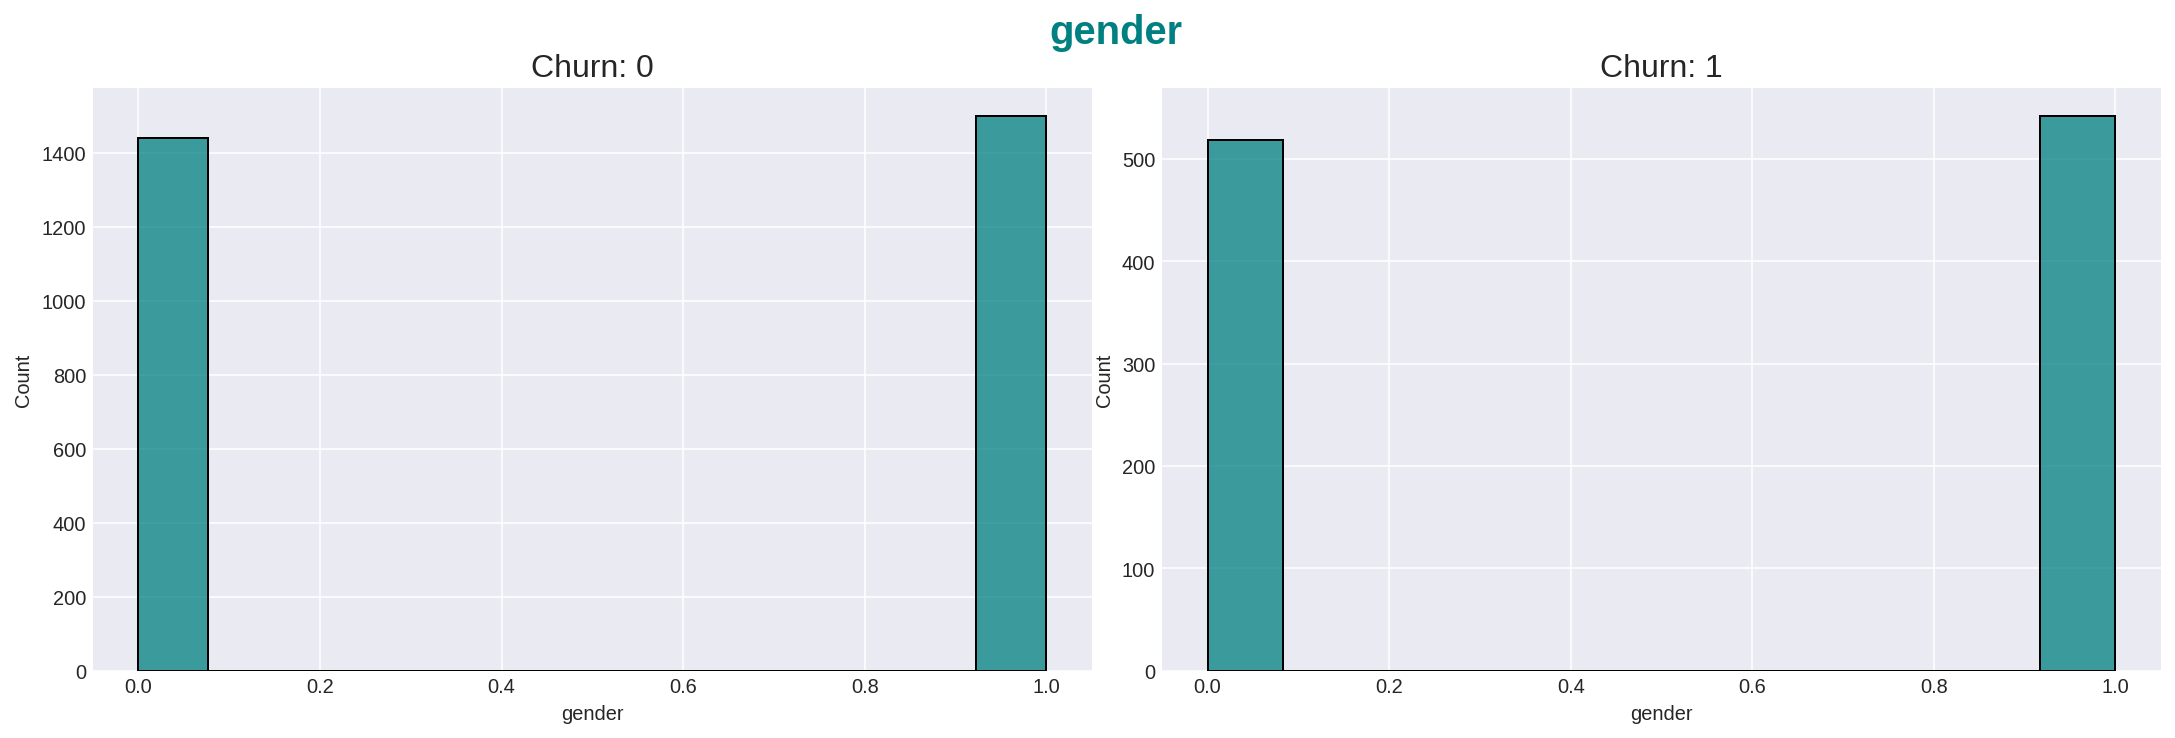

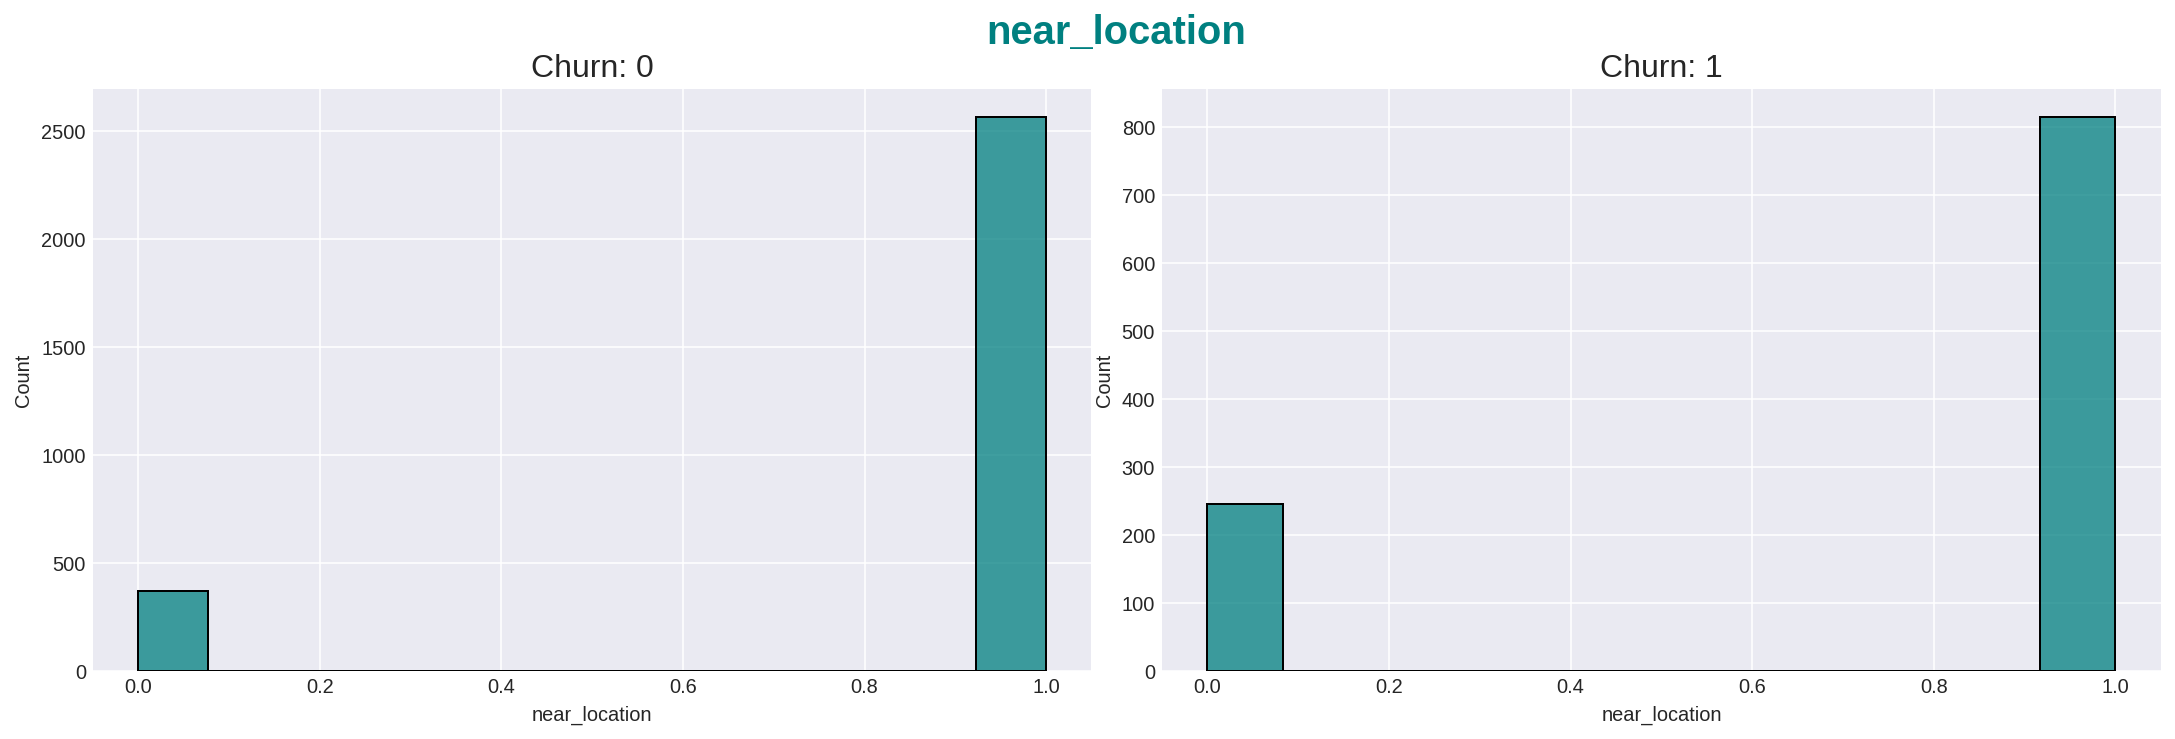

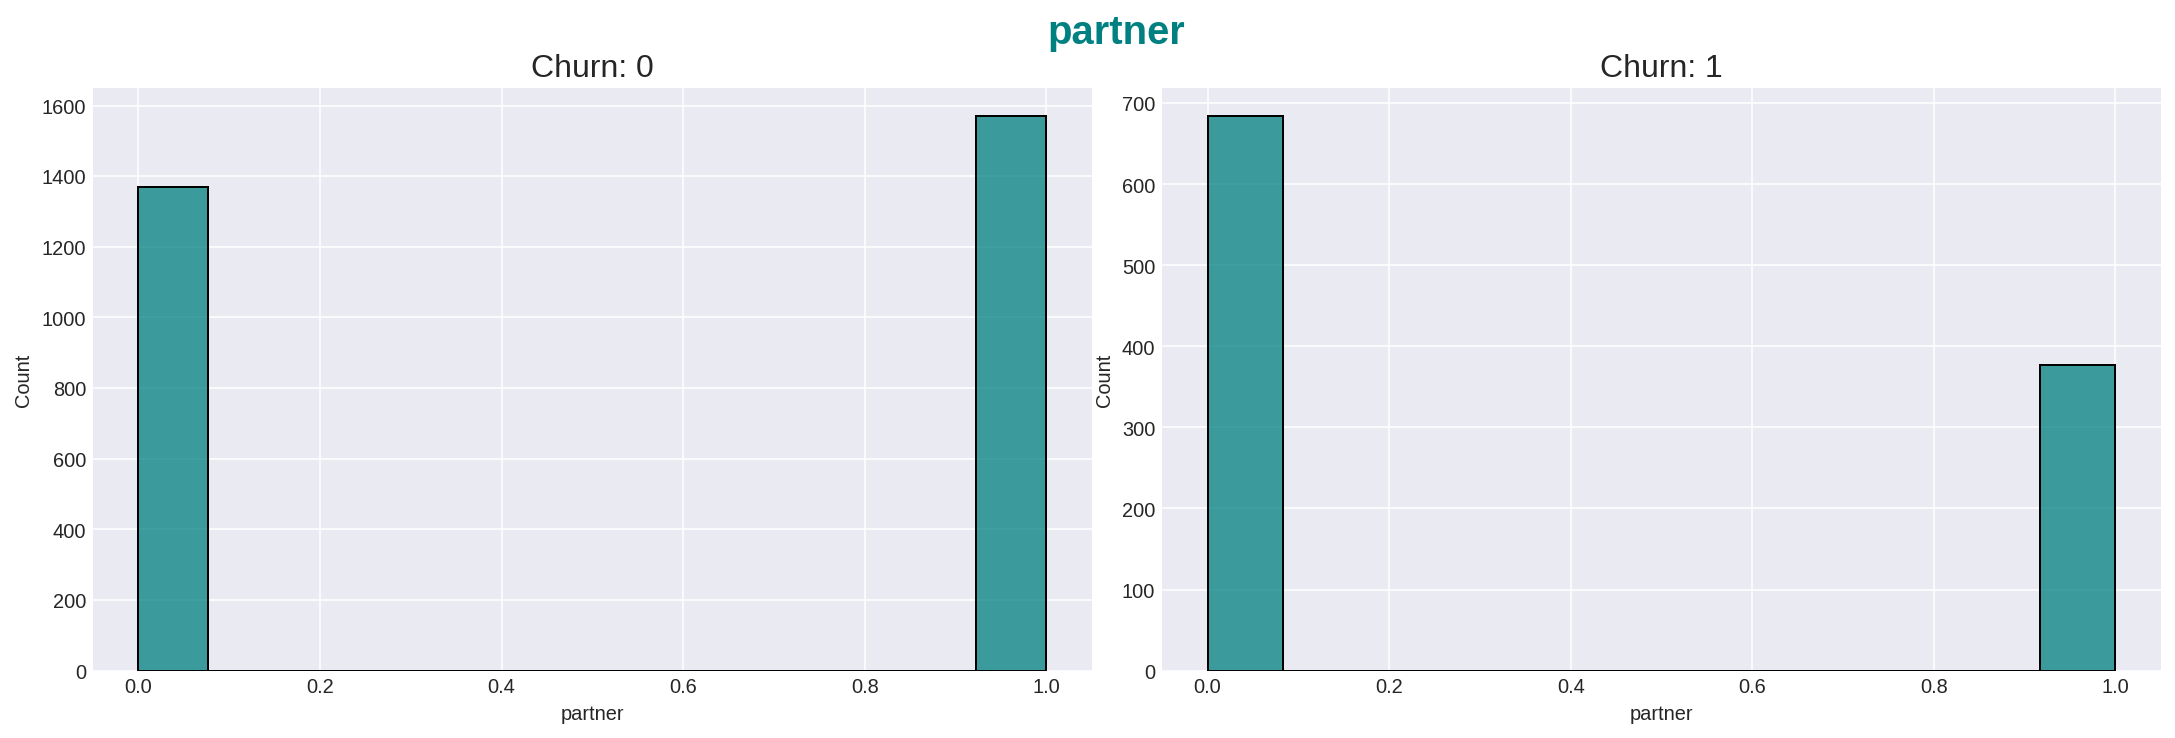

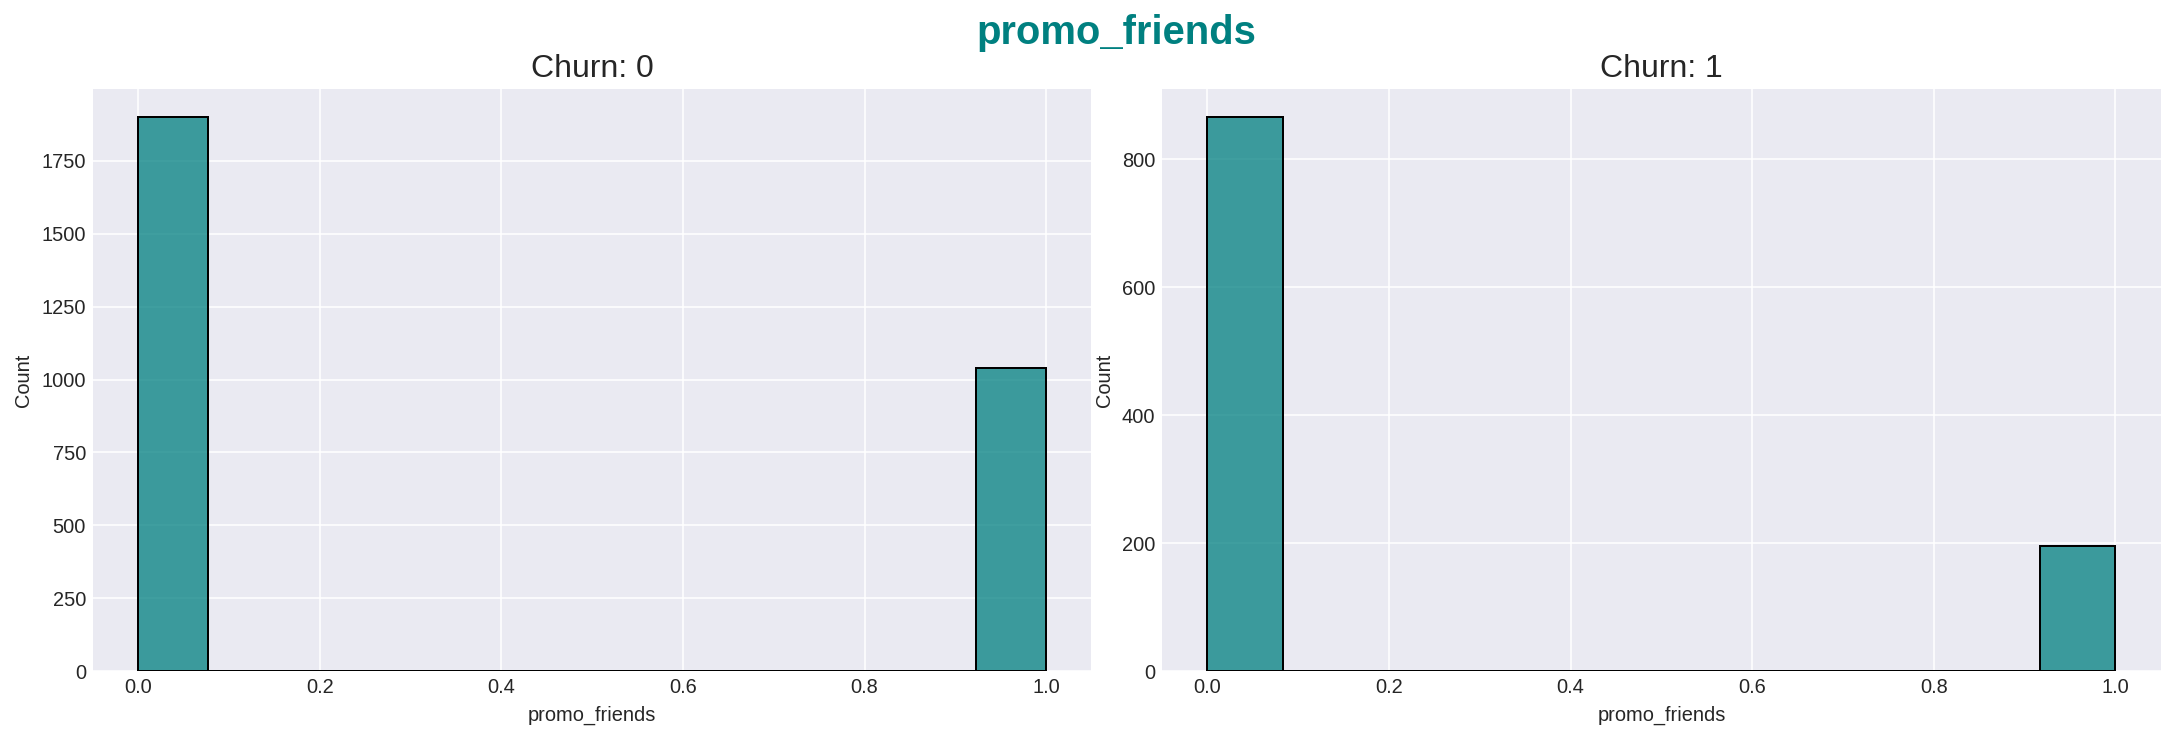

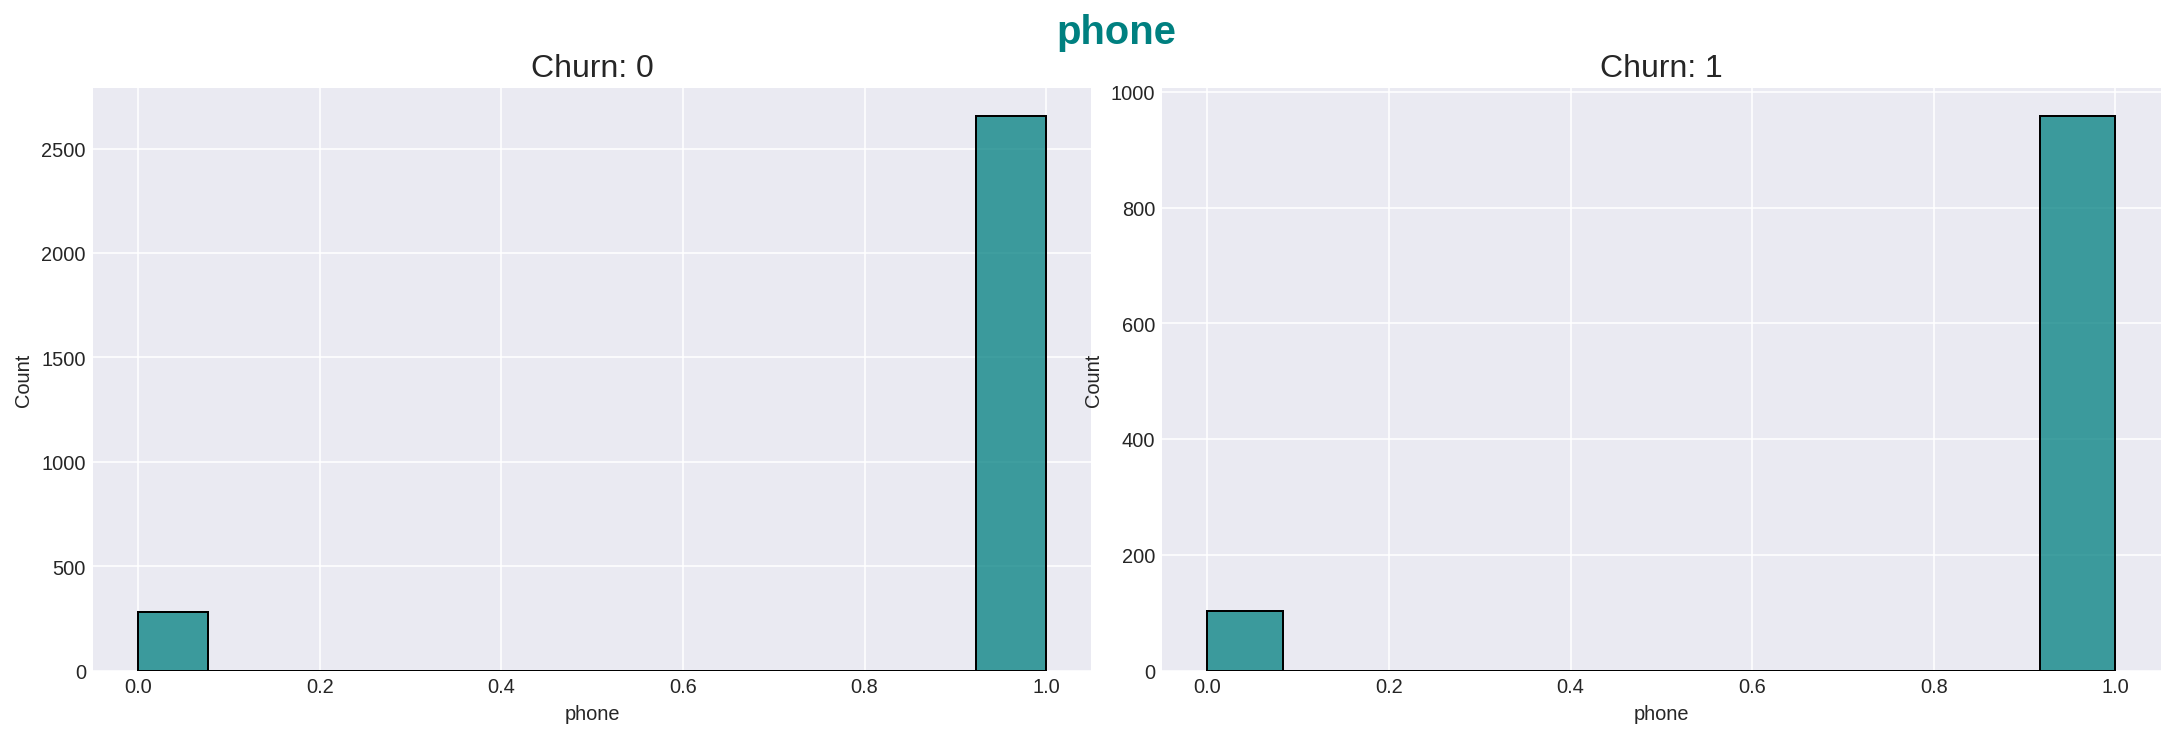

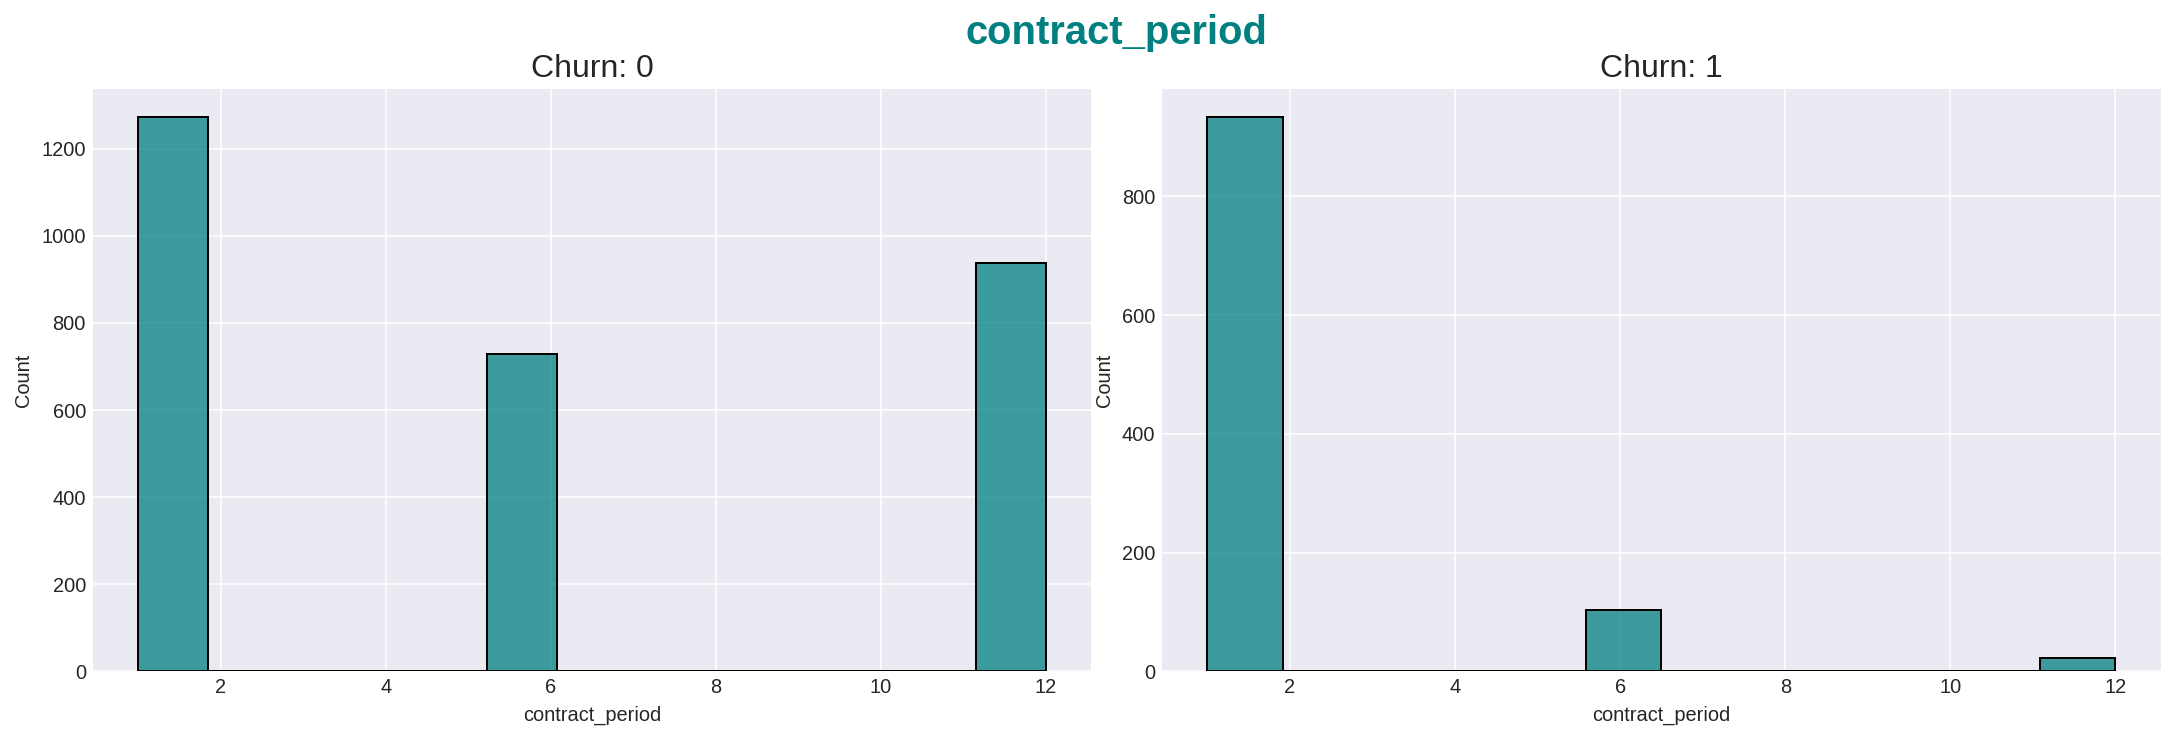

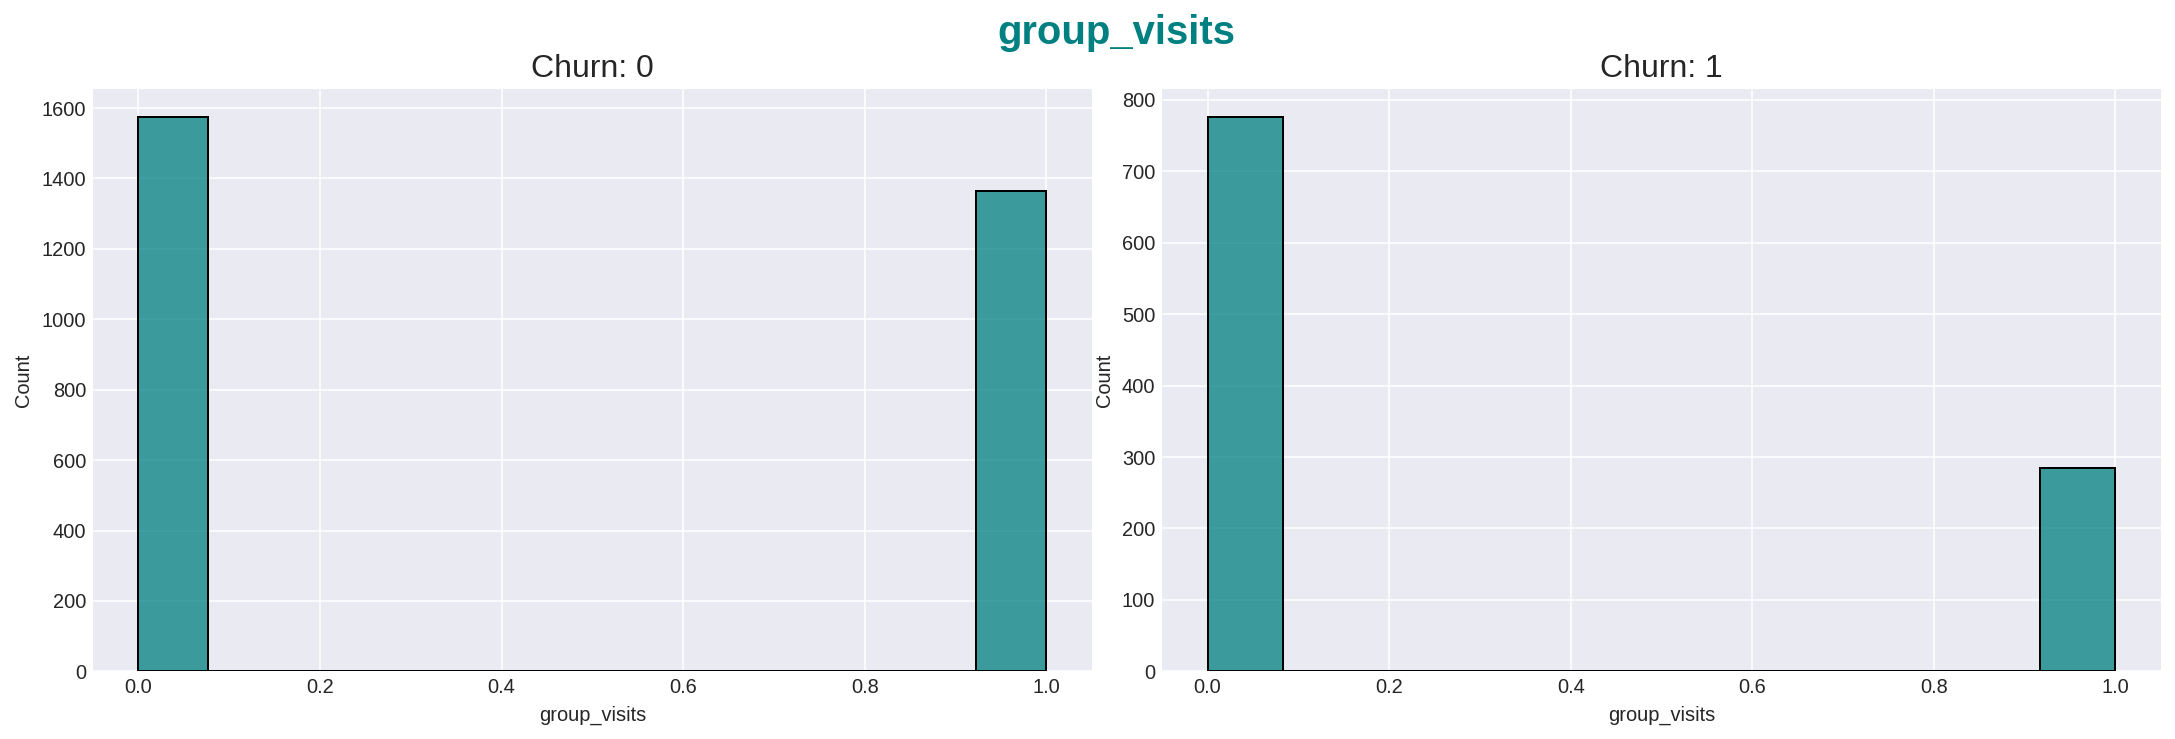

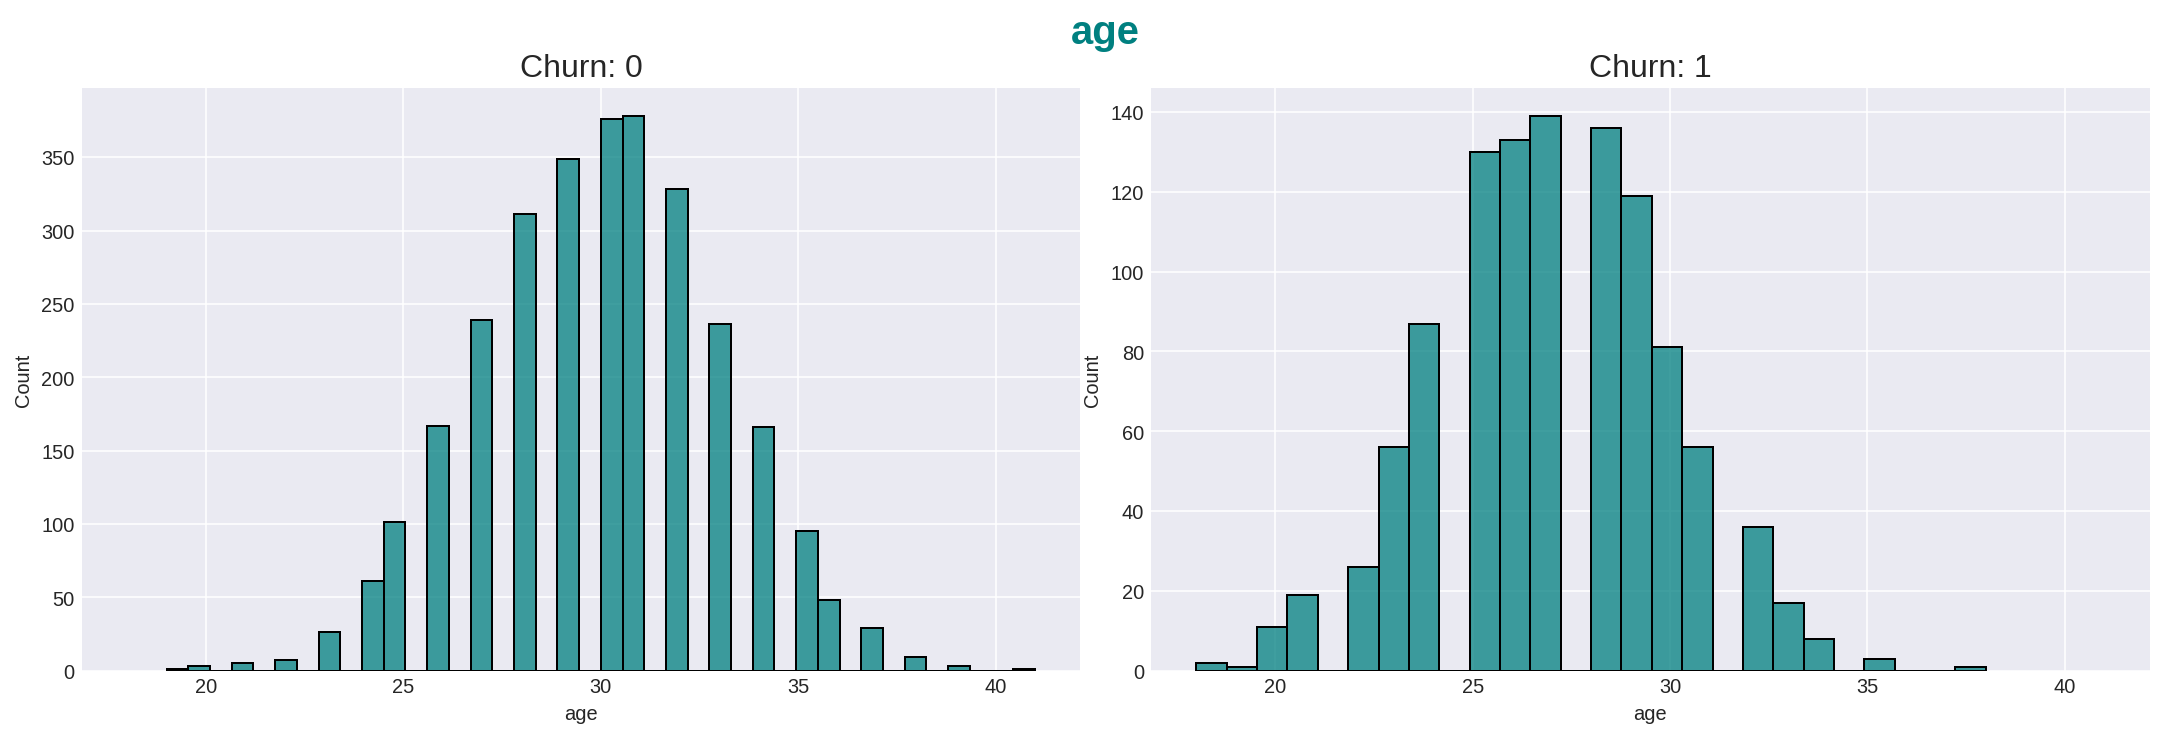

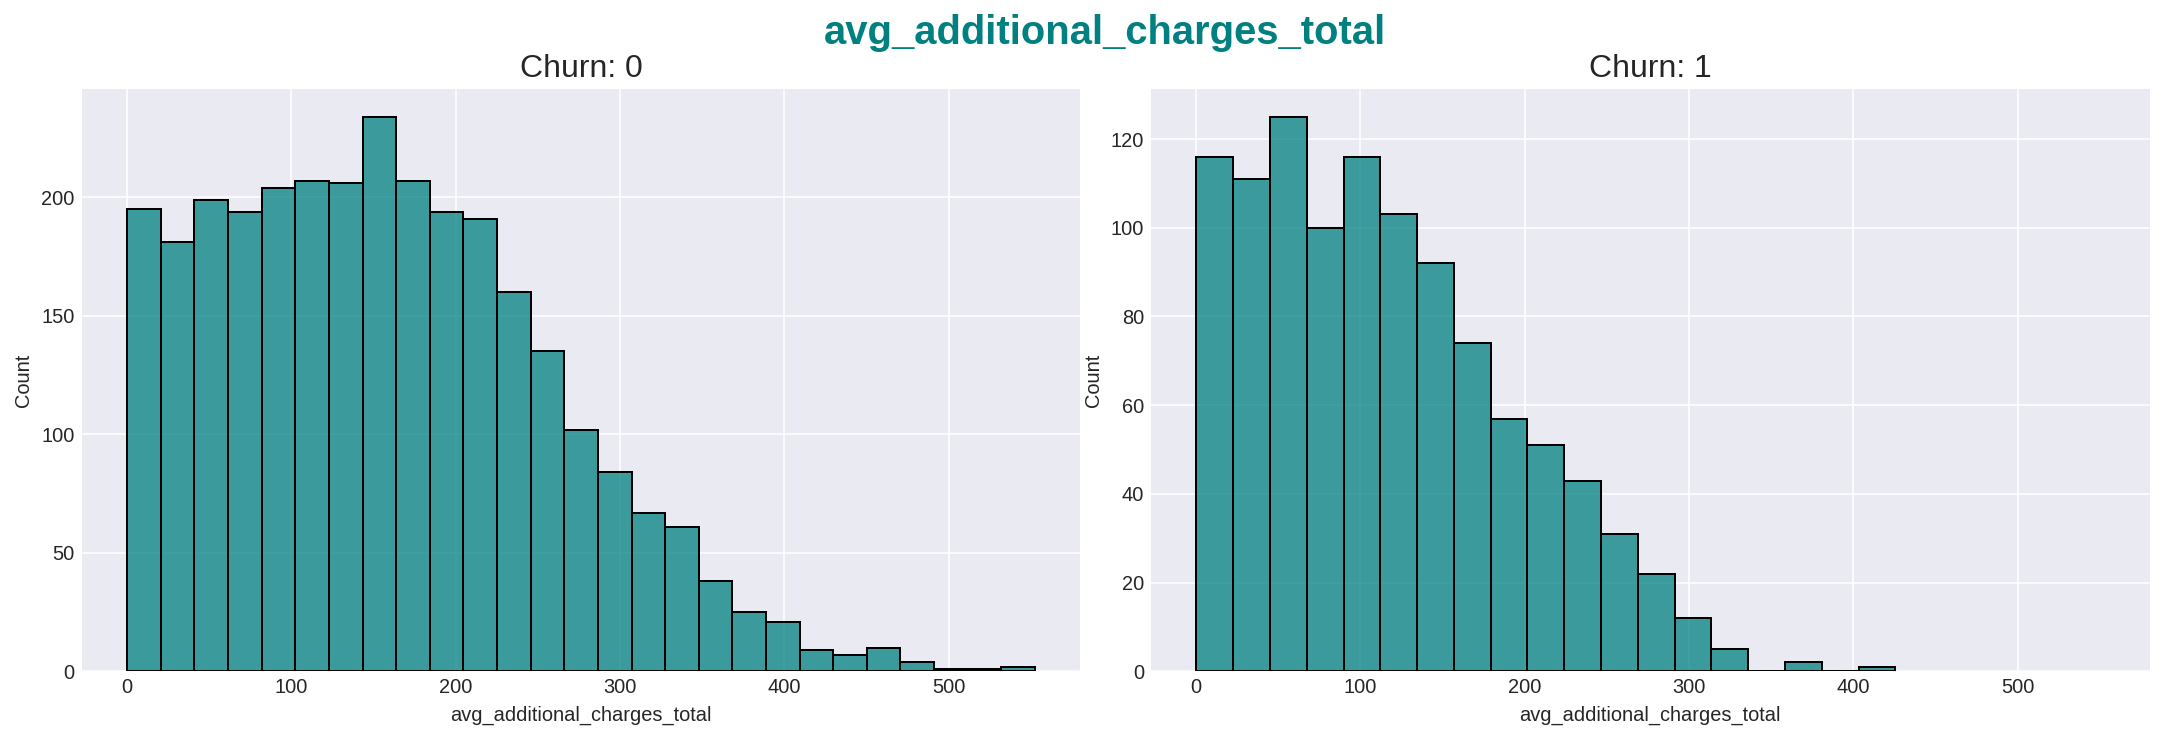

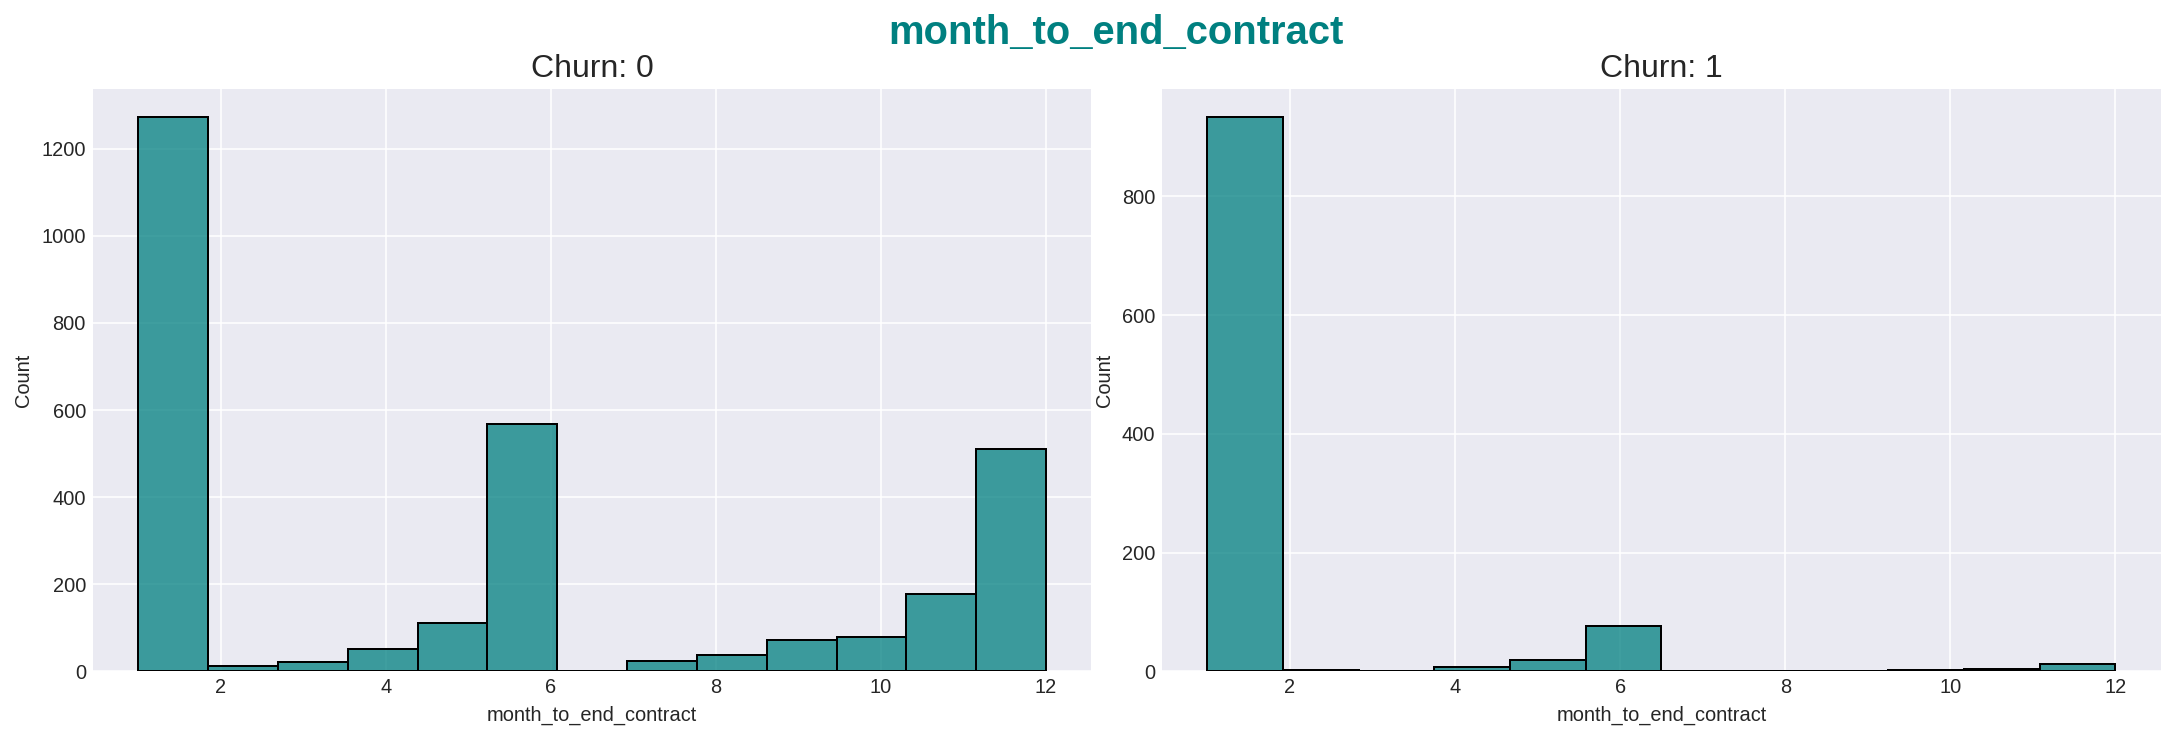

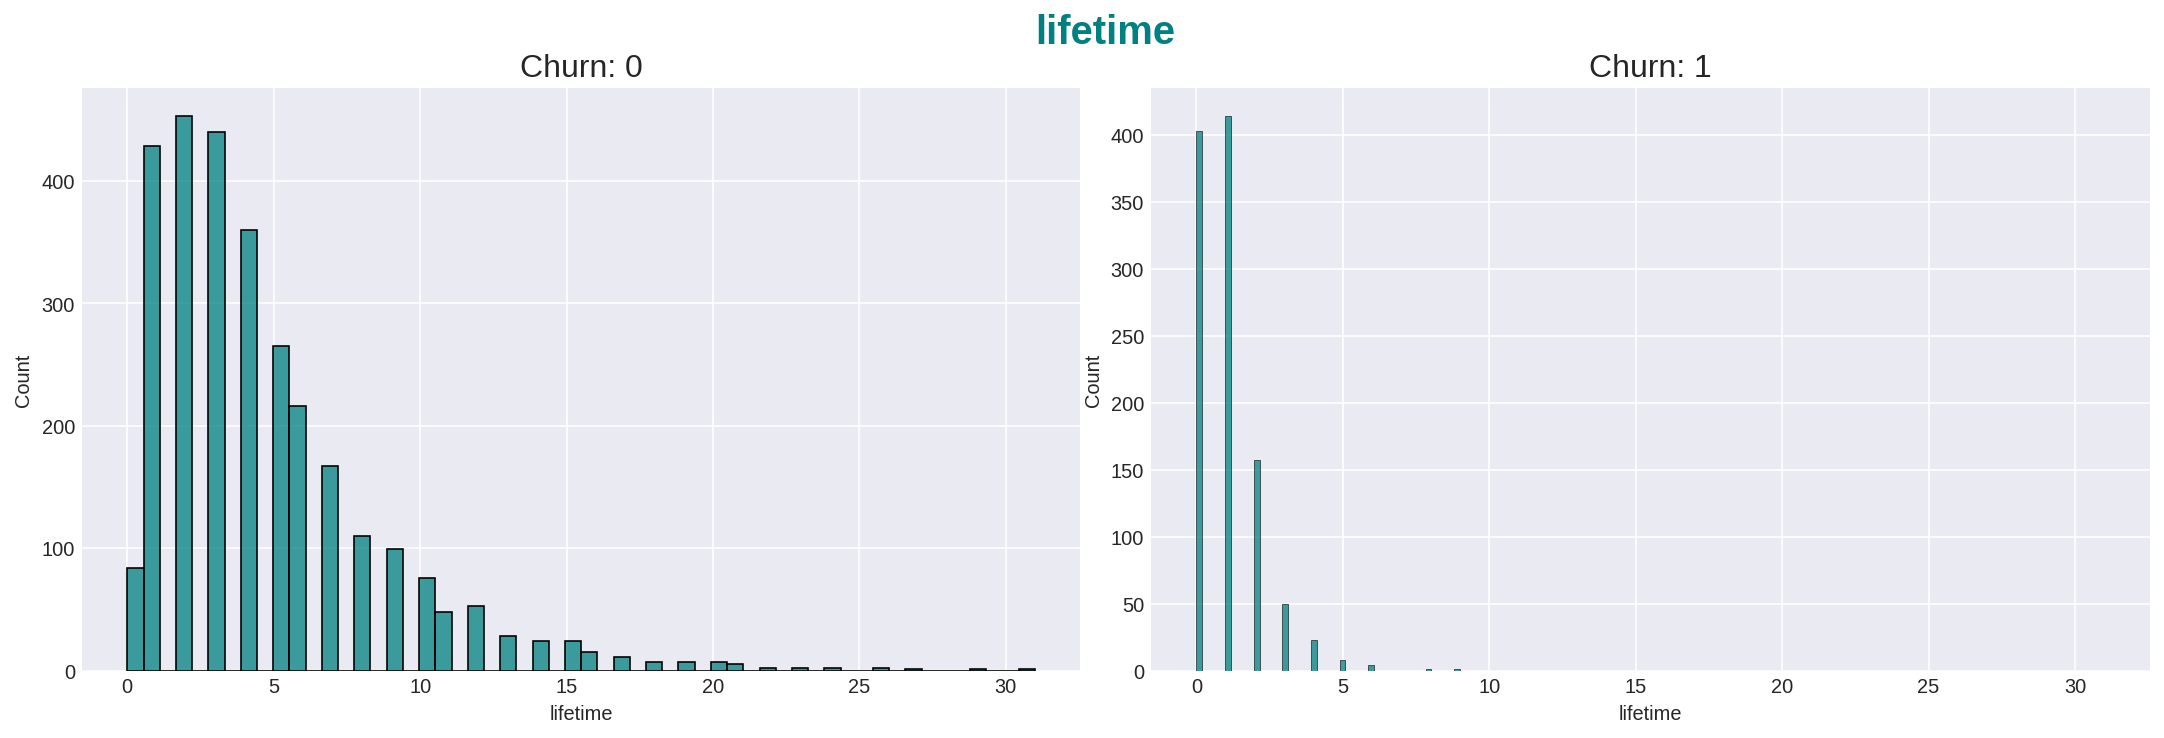

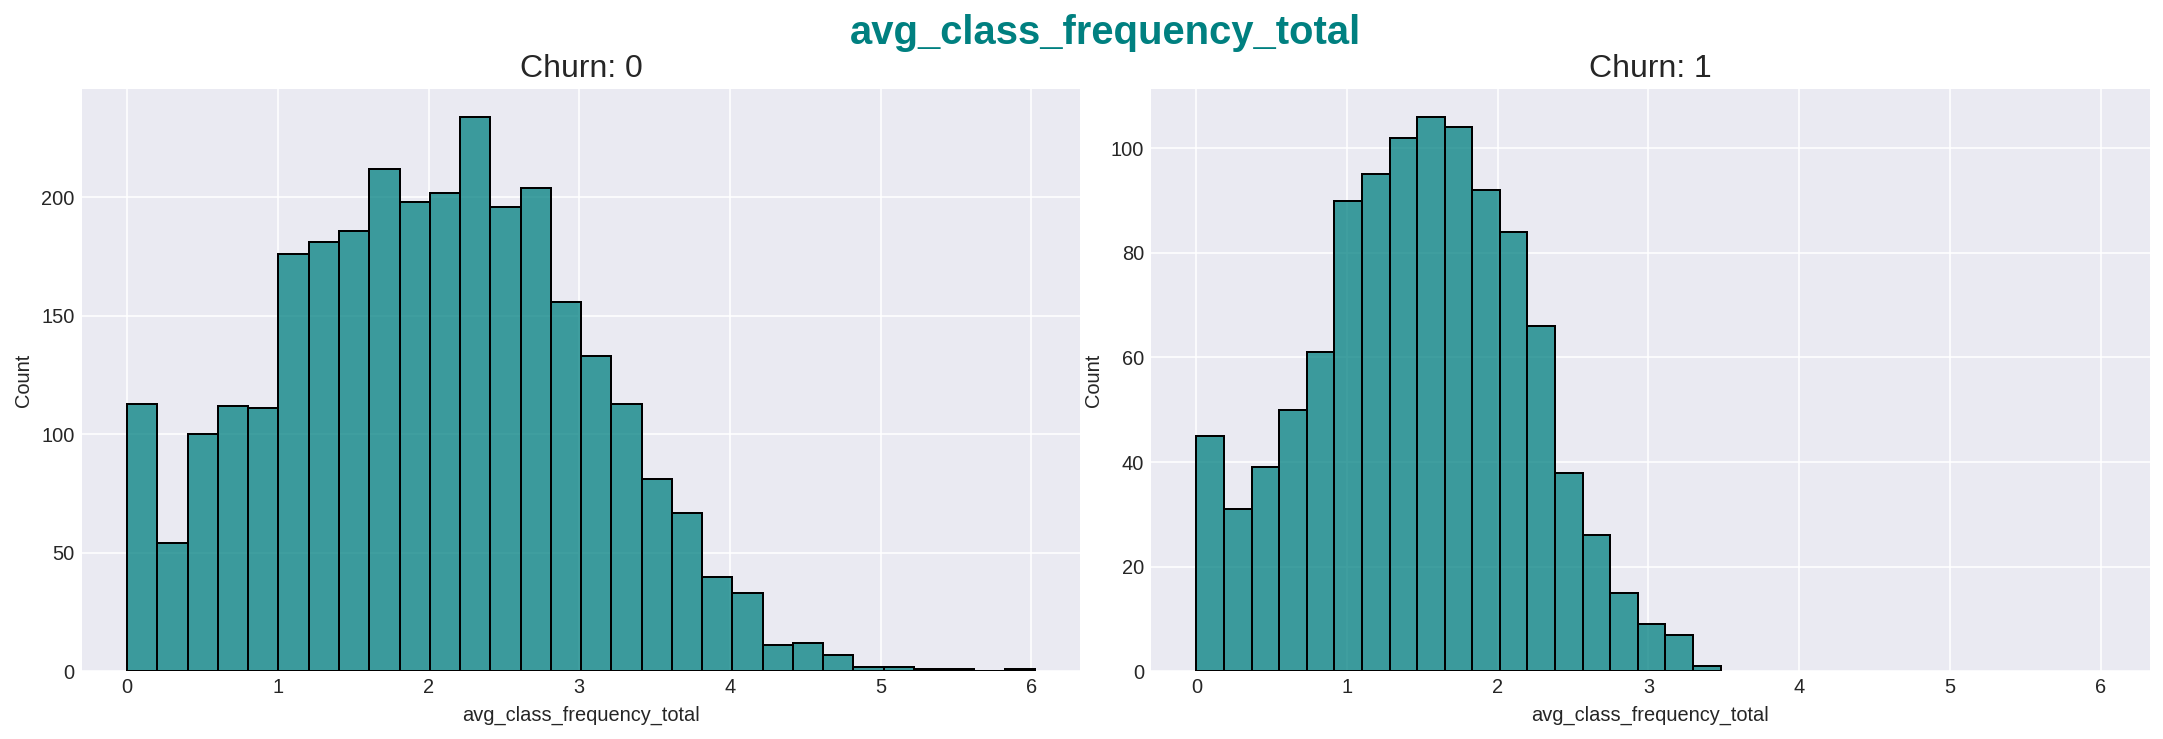

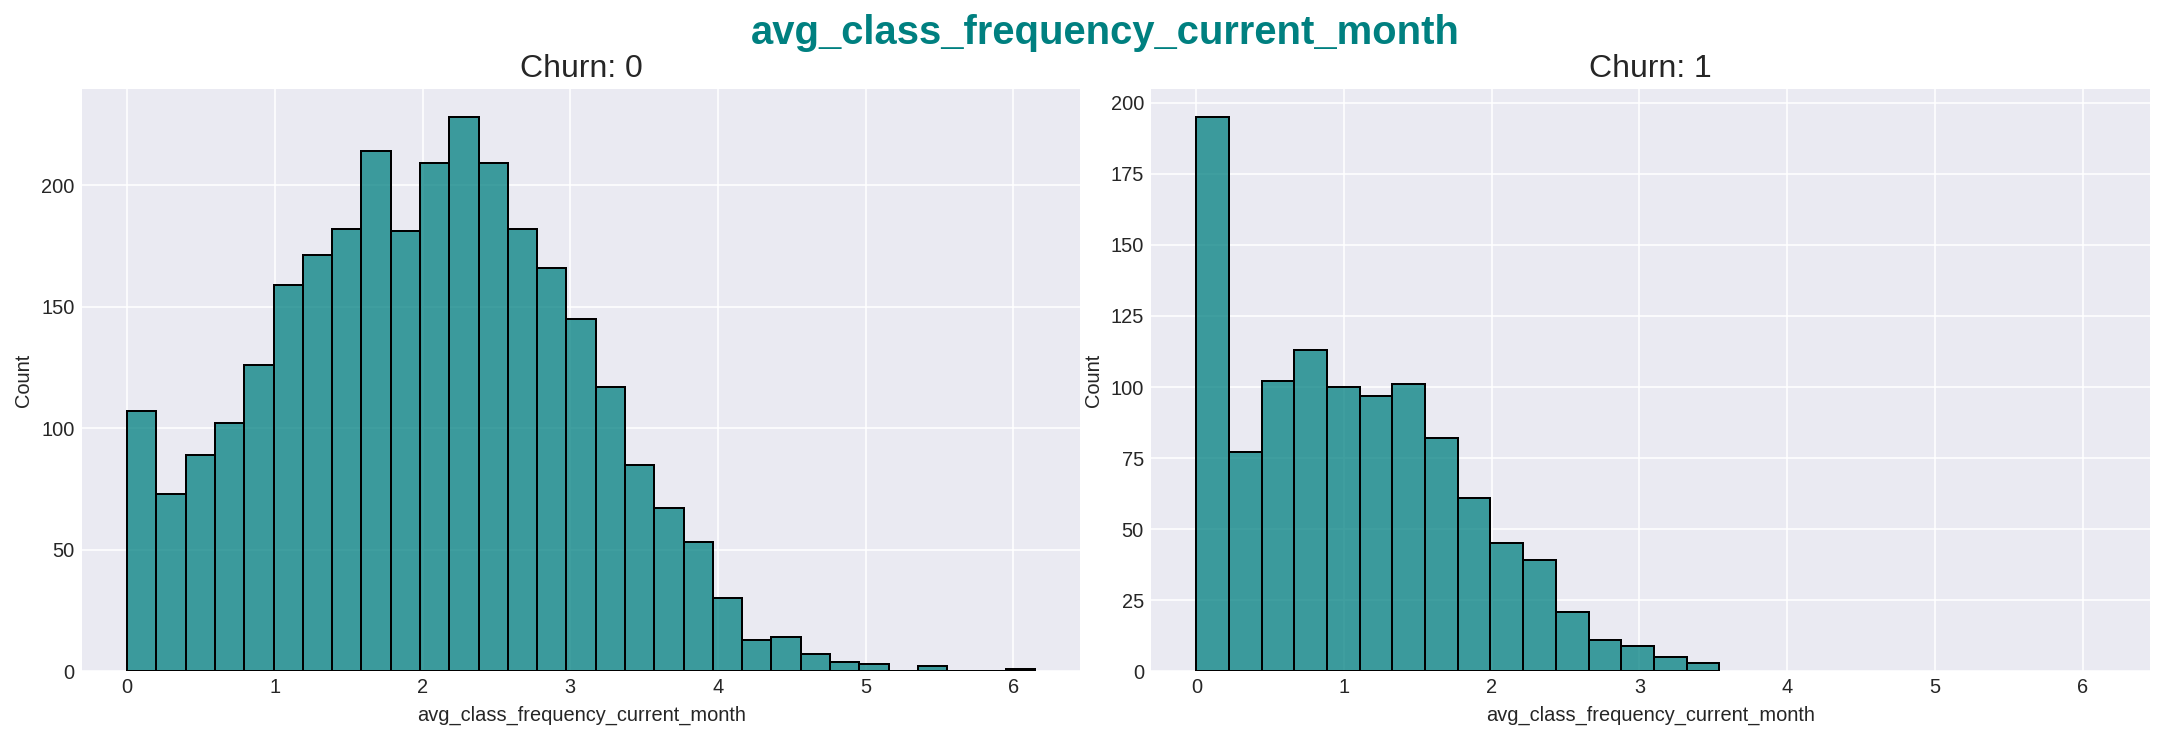

In [11]:
double_hist('churn')

Кроме прошлых выводов можно добавить следующее:
1. Почти у всех ушедших клиентов были месячные контракты. По какой-то причине они решили их не продлевать.
2. Почти все ушедшие клиенты пользовались услугами клуба не более 2 месяцев.
3. На гистограмме среднего количества посещений за последний месяц виден выброс в нуле. Перед тем, как уйти, многие перестали пользоваться услугами центра.

Построим матрицу корреляций, чтобы посмотреть, как разные признаки связаны друг с другом.

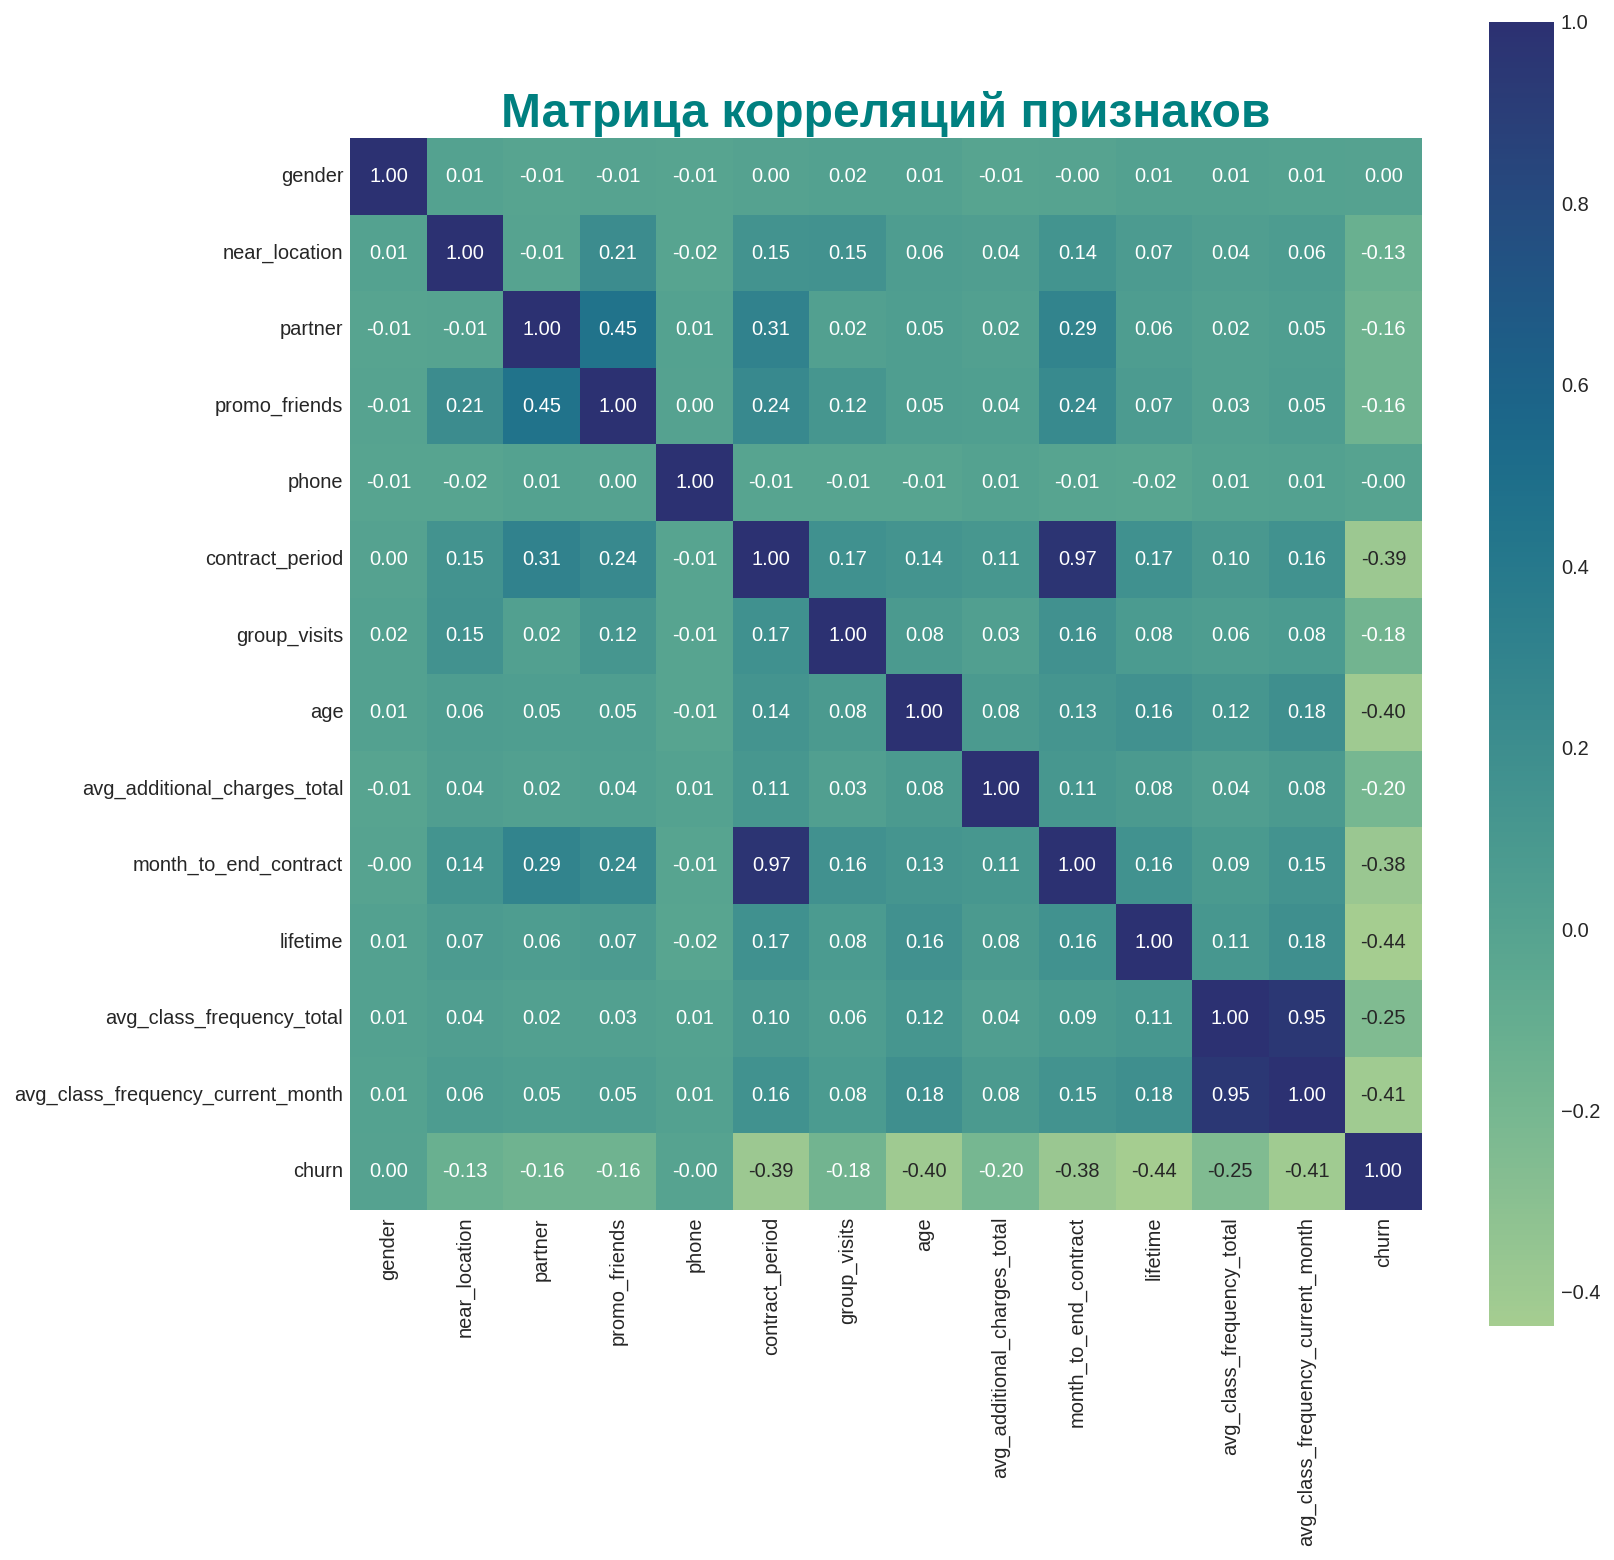

In [12]:
plt.figure(figsize=(12, 12))
plt.title('Матрица корреляций признаков', fontsize=24, fontweight='bold', color='teal')
sns.heatmap(df.corr(), square=True, annot=True, fmt='.2f', cmap='crest');

1. Длительность договора и количество месяцев до конца договора, что логично, сильно связаны.
2. По той же логике связаны среднее количество посещений в текущем месяце и в целом.
3. С оттоком больше всего коррелируют «время жизни», частота посещений, срок договора и возраст клиента.

## Обучаем классификаторы

Разделим датасет на признаки и целевую переменную.

In [13]:
X = df.drop('churn', axis=1)

In [15]:
y = df['churn']

Для валидации разделим выборку на две части: обучающую и тестовую.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

Создадим переменную с моделью логистической регрессии и обучим её на train-выборке.

In [17]:
log_reg = LogisticRegression(random_state=11, solver='liblinear')

In [18]:
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=11, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Предсказанные значения запишем в отдельную переменную.

In [19]:
y_lr_pred = log_reg.predict(X_test)

Для простоты подсчёта метрик создадим словарь и функцию. Она будет принимать вектор предсказанных значений, а возвращать список метрик и их величину.

In [20]:
metrics = {'accuracy_score': accuracy_score,
           'precision_score': precision_score,
           'recall_score': recall_score,
           'f1_score': f1_score}

In [21]:
def scores(y):
    for k, v in metrics.items():
        print(k + ':', v(y_test, y))

Посчитаем метрики для нашей модели.

In [22]:
scores(y_lr_pred)

accuracy_score: 0.92375
precision_score: 0.9179487179487179
recall_score: 0.7991071428571429
f1_score: 0.8544152744630072


Учитывая дисбаланс классов, метрика accuracy для нас почти бесполезна. Лучше рассмотреть другие.  
У нашей можели высокая точность и неплохая полнота. Учитывая, что нам важно не упустить клиента, который вот-вот уйдёт, полнота для нас важнее. Её стоит повысить. Метрика F1, которая отвечает за баланс точности и полноты, также получилась довольно высокими.

Теперь обучим модель случайного леса.

In [23]:
rf = RandomForestClassifier(criterion='entropy', random_state=11, n_estimators=100)

In [24]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=11, verbose=0,
                       warm_start=False)

Посмотрим на важность параметров.

In [25]:
pd.DataFrame(rf.feature_importances_, list(X_train)).sort_values(0, ascending=False)

,0
lifetime,0.266675
avg_class_frequency_current_month,0.170915
age,0.131286
avg_class_frequency_total,0.130388
avg_additional_charges_total,0.093102
contract_period,0.071643
month_to_end_contract,0.067853
group_visits,0.015147
gender,0.012628
partner,0.012085


В целом важность фич соотносится с той, которую мы получили на матрице корреляций.

Предскажем значения целевой переменной на тестовой выборке и посчитаем метрики.

In [26]:
y_rf_pred = rf.predict(X_test)

In [27]:
scores(y_rf_pred)

accuracy_score: 0.9
precision_score: 0.875
recall_score: 0.75
f1_score: 0.8076923076923077


Случайный лес справился хуже логистической регрессии: все метрики оказались несущественно, но ниже. Попробуем усовершенствовать модель регрессии. Для начала создадим вектор вероятностей отнесения к определенному классу.

In [28]:
prob_train = log_reg.predict_proba(X_train)[:, 1]
prob_test = log_reg.predict_proba(X_test)[:, 1]

При помощи цикла посчитаем F1 для каждого порога отнесения к классу от 0 до 0.999 с шагом в 0.001

In [29]:
f1_list = []
for i in range(1000):
    th = i / 1000
    cp = [0 if i < th else 1 for i in prob_train]
    f1 = f1_score(y_train, cp)
    f1_list.append([th, f1])

Сделаем из списка датафрейм.

In [30]:
f1_df = pd.DataFrame(f1_list, columns=['threshold', 'f1'])

In [31]:
f1_df[f1_df['f1']==f1_df['f1'].max()]

,threshold,f1
480,0.480,0.870043
481,0.481,0.870043


При значениях порога 0.480 и 0.481 F1 максимальный из возможных для нашей модели. Выберем этот порог и посчитаем для него все метрики на тестовом множестве.

In [32]:
threshold = 0.48

In [33]:
custom_pred = [0 if i < threshold else 1 for i in prob_test]

In [34]:
scores(custom_pred)

accuracy_score: 0.925
precision_score: 0.91
recall_score: 0.8125
f1_score: 0.8584905660377358


Полнота также немного выросла. Для нас это хорошо: более 81% клиентов, склонных уйти, мы сможем обнаружить и попытаться переубедить.

## Разделяем на кластеры

Перед кластеризацией необходимо стандартизировать данные.

In [35]:
ss = StandardScaler()

In [36]:
X_sc = ss.fit_transform(X)

Построим дендрограмму, чтобы посмотреть на потенциальное количество кластеров клиентов.

In [37]:
link = linkage(X_sc, method='ward')

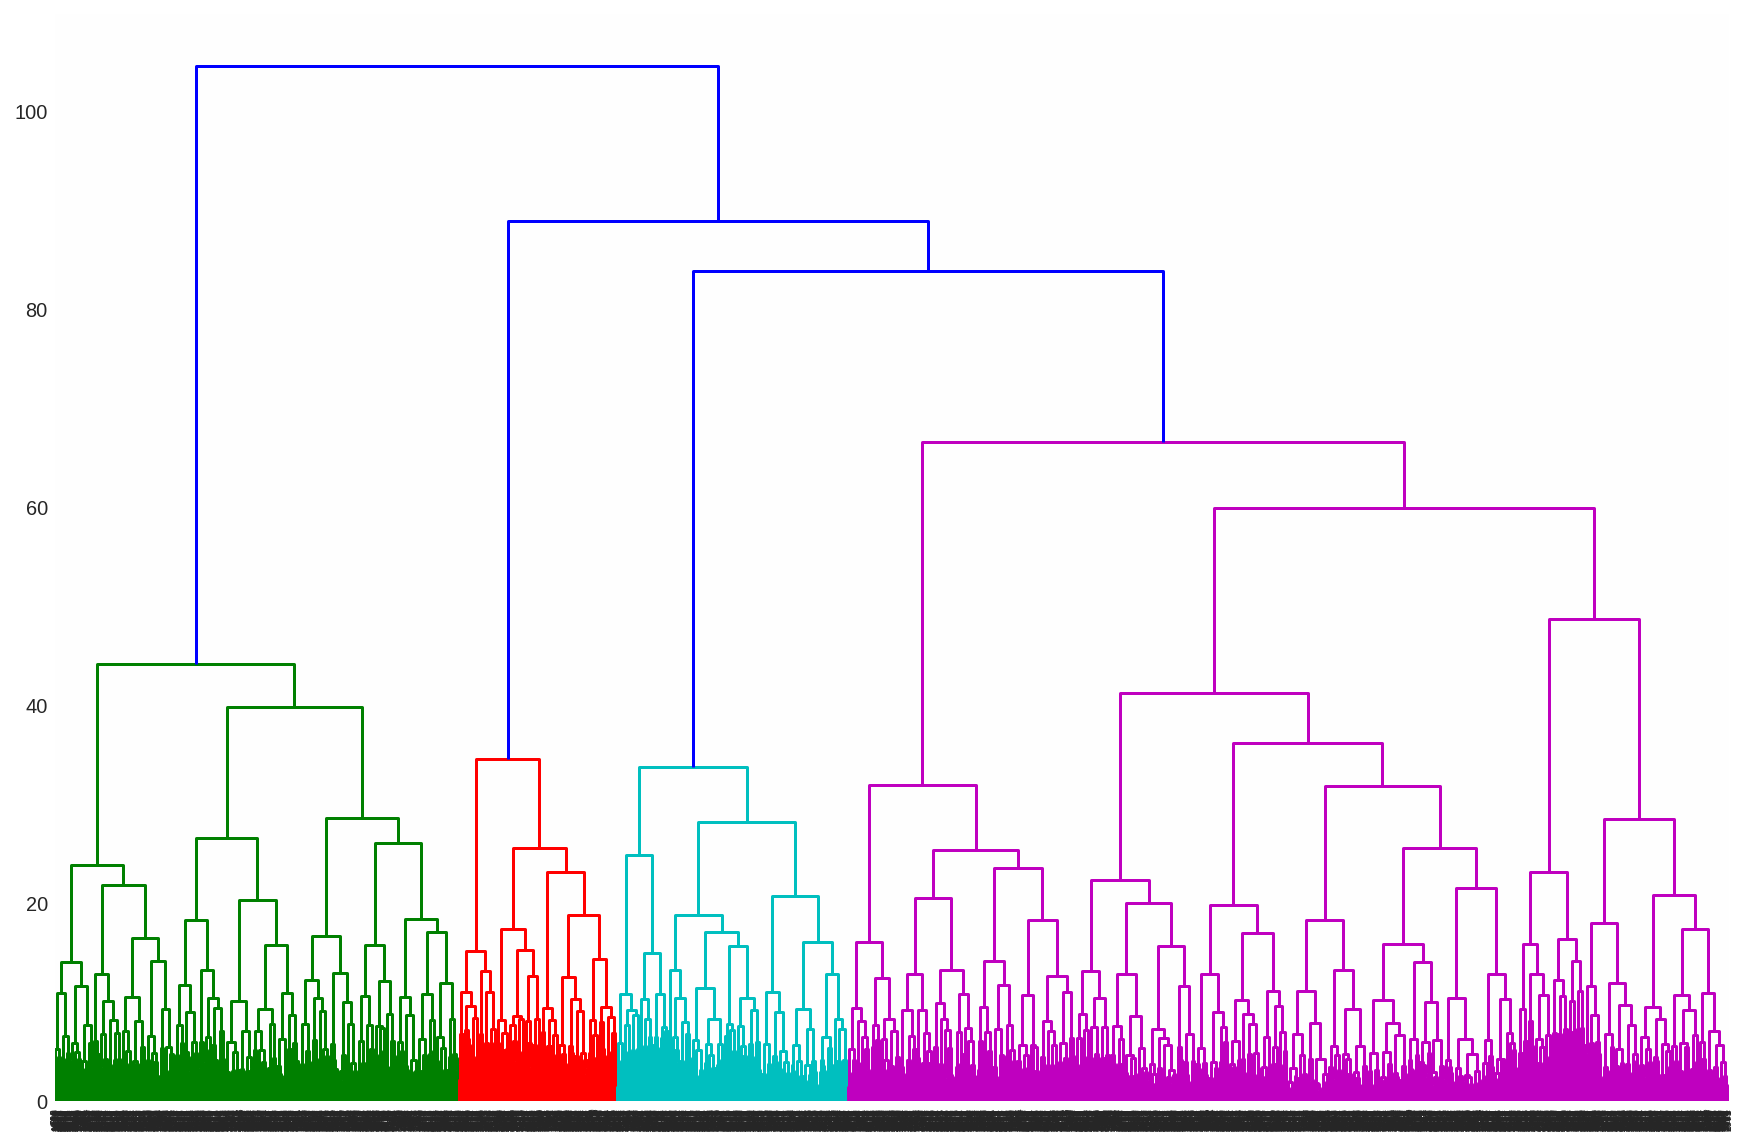

In [38]:
plt.figure(figsize=(15, 10))  
dendrogram(link, orientation='top')
plt.show()

Можно выделить 4 кластера, однако последний кластер получился довольно большим. Разделим выборку на 5 кластеров при помощи метода K-средних.

In [39]:
km = KMeans(n_clusters=5, random_state=11)
labels = km.fit_predict(X_sc)

In [40]:
df['cluster'] = labels

Посчитаем средние значения параметров для каждого кластера.

In [41]:
df.groupby('cluster').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.486312,1.000000,0.353462,0.239936,1.0,1.959742,0.341385,28.156200,130.646233,1.869565,2.370370,1.236788,0.999501,0.519324
1,0.497041,0.000000,0.461538,0.078895,1.0,2.378698,0.218935,28.479290,135.631940,2.224852,2.812623,1.662253,1.480228,0.441815
2,0.501478,0.960591,0.782266,0.574384,1.0,10.882759,0.540887,29.979310,160.817799,9.944828,4.723153,1.996640,1.989817,0.027586
3,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839
4,0.557647,0.977647,0.350588,0.229412,1.0,2.582353,0.470588,30.105882,162.179380,2.380000,4.957647,2.817542,2.813218,0.071765


Основные признаки кластеров такие:
1. **Кластер 0:** Пользователи живут рядом с клубом, чуть реже среднего пользуются партнерской программой или акцией «приведи друга». Срок контракта у них в основном короткий. Больше половины людей из этого кластера ушли. Нельзя сказать, что у этих клиентов есть явные предпосылки для ухода. Возможно, есть причины, которые не отследить при помощи наших данных (внутренняя мотивация или недовольство услугами).
2. **Кластер 1:** Почти половина клиентов из этого кластера ушли — скорее всего потому, что они не живут рядом с клубом и им трудно до него добираться.
3. **Кластер 2:** Самые лояльные пользователи, коэффициент оттока меньше 3%. Большинство людей из этого кластера пришли по партнерской программе и купили абонемент на год. Они замотивированы продолжать заниматься.
4. **Кластер 3:** Все значения получились близкими к средним, которые мы получили в самом начале методом `describe`. В том числе и коэффициент оттока. Отличается только наличие номера телефона, которое, как мы выяснили раньше, никак не влияет на отток.
5. **Кластер 4:** Сюда также попали лояльные клиенты, 93% из них продолжают пользоваться услугами клуба. У них высокий lifetime, они активно пользуются услугами и часто занимаются, но средняя продолжительность абонемента небольшая. Возможно, это преданные клиенты, для которых годовой абонемент слишком дорогой.

Теперь при помощи ранее написанной функции построим гистограммы признаков по каждому кластеру.

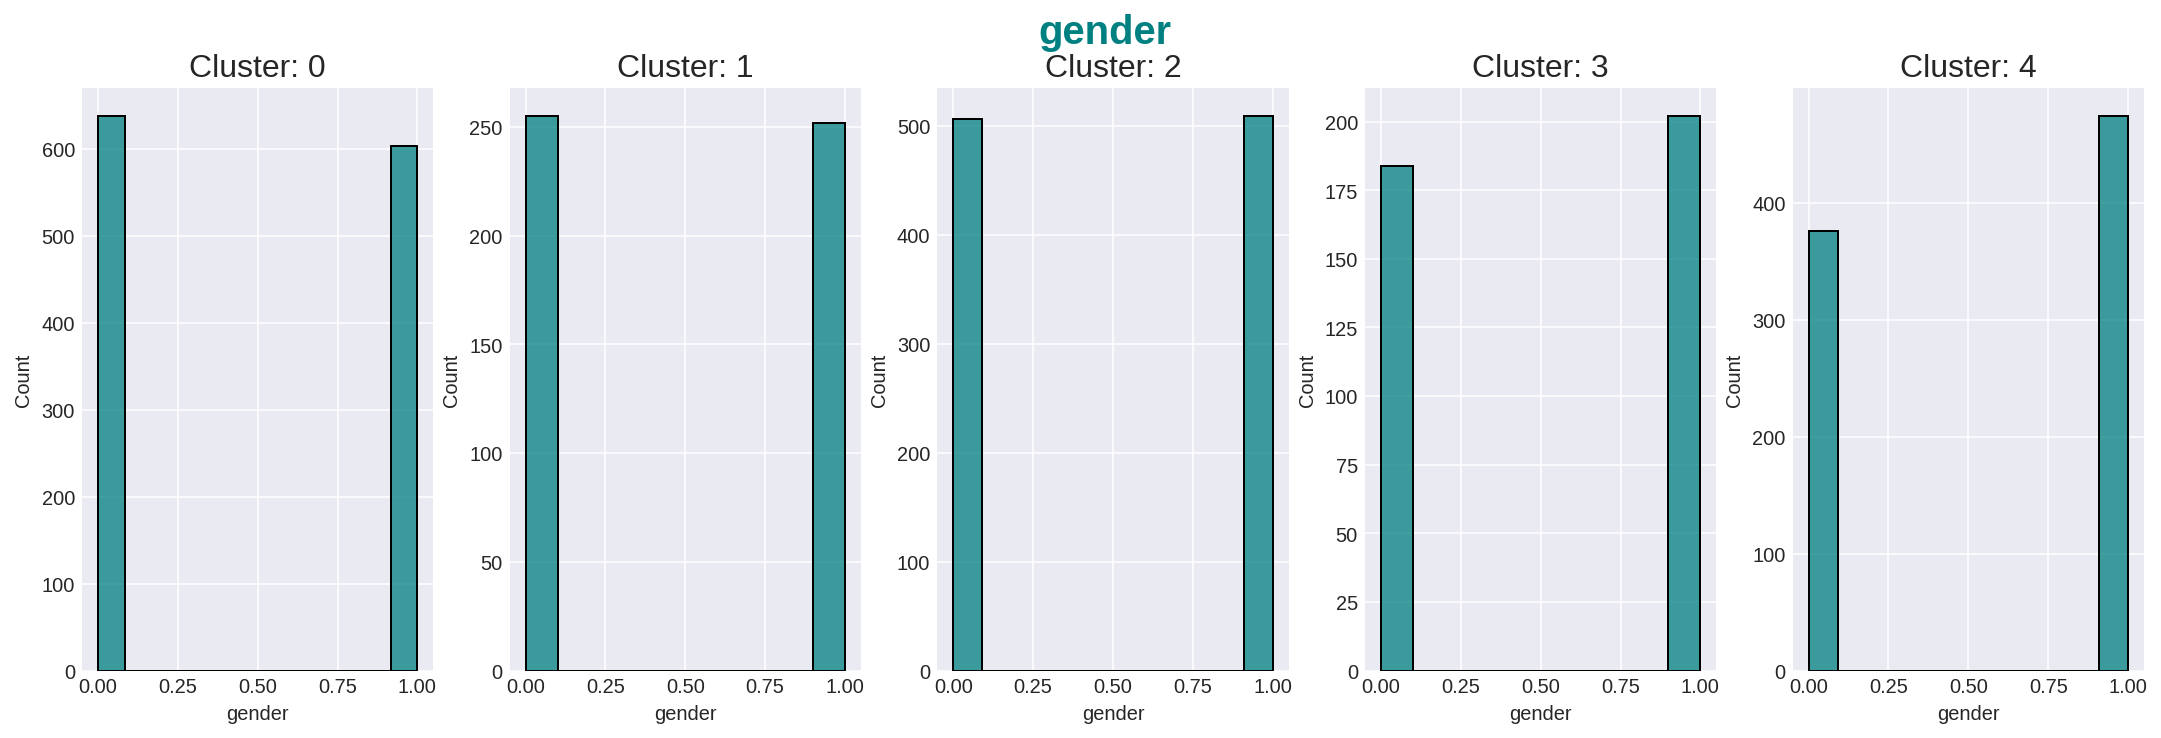

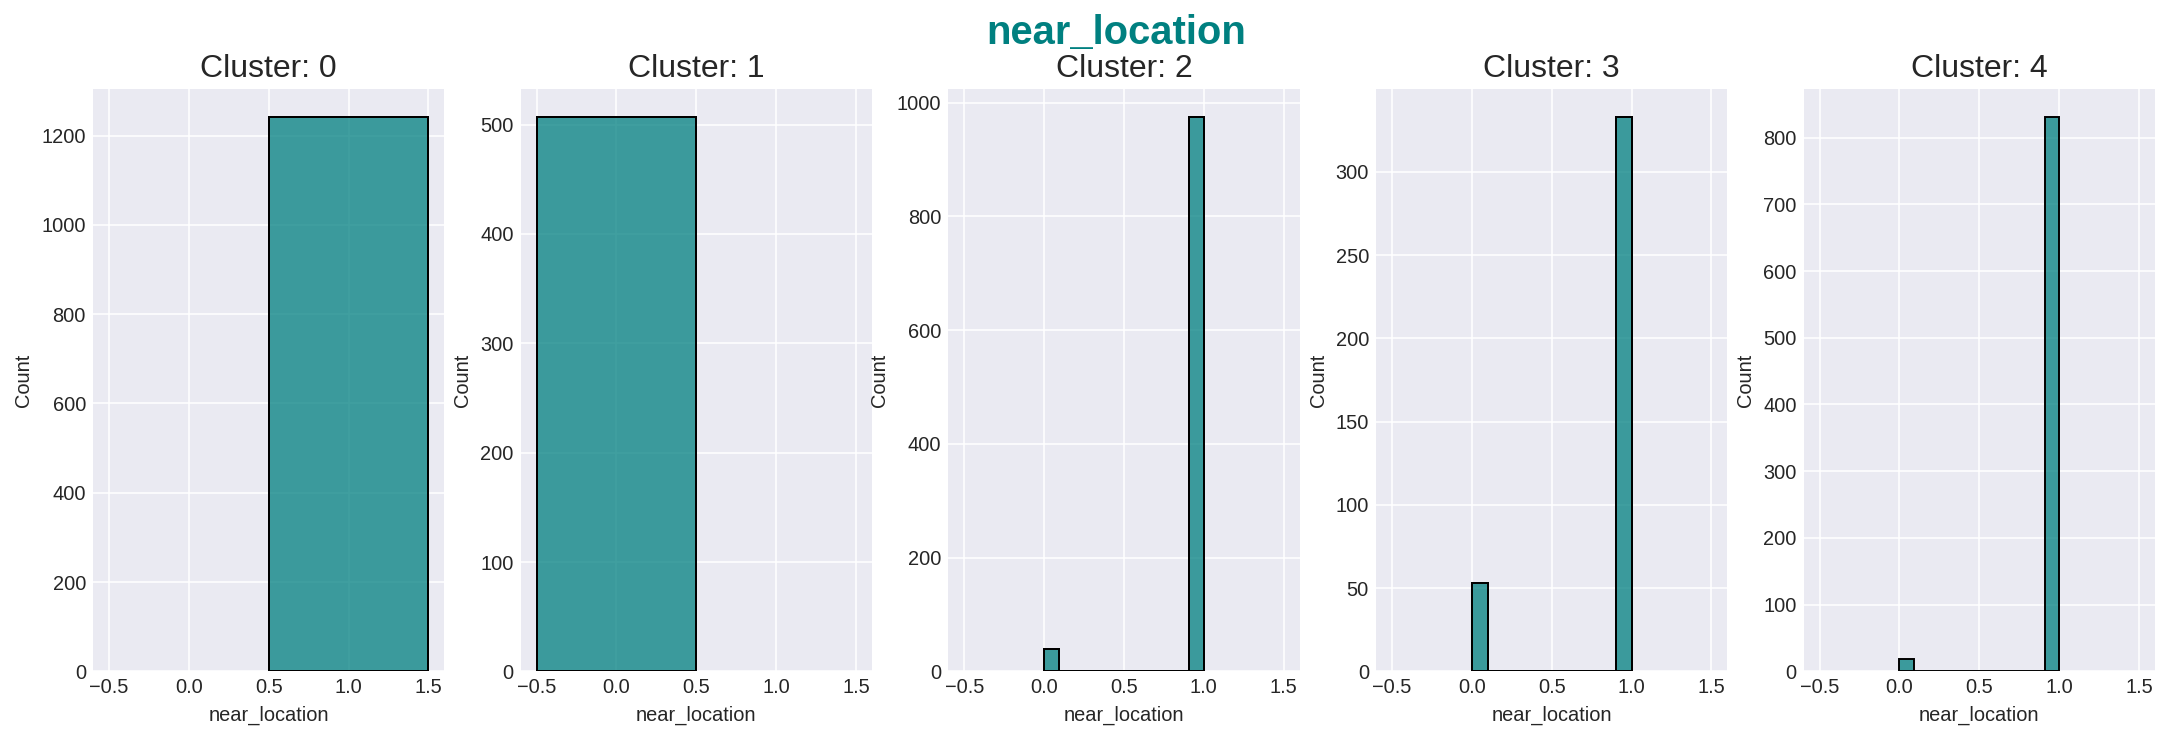

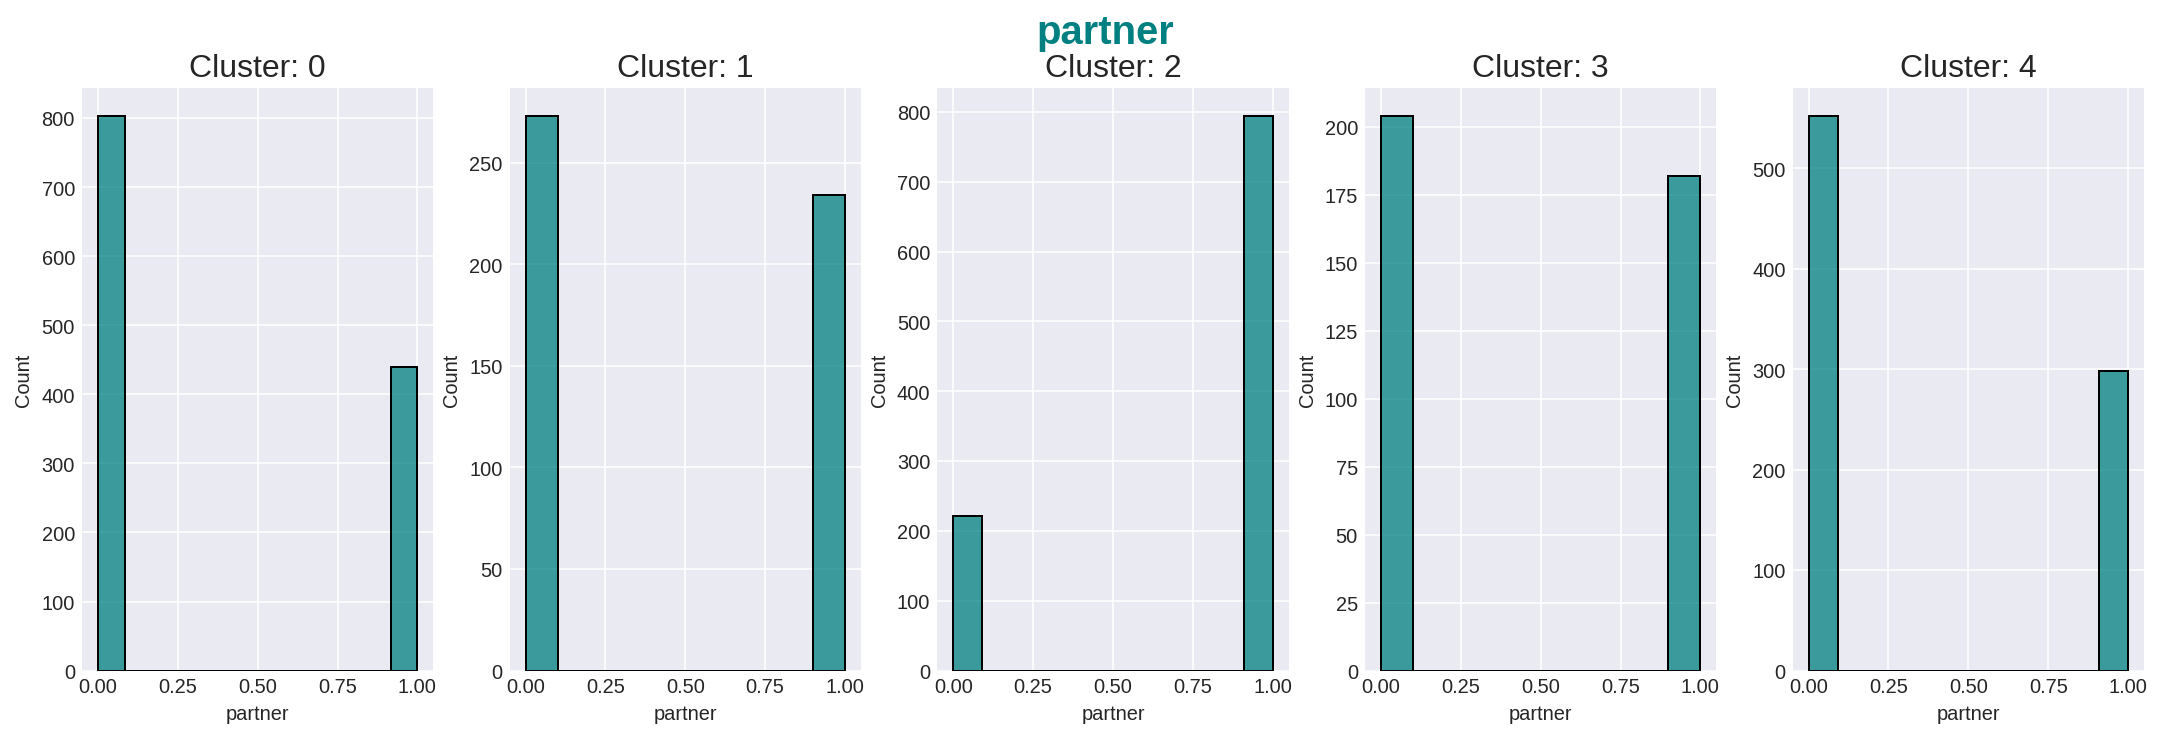

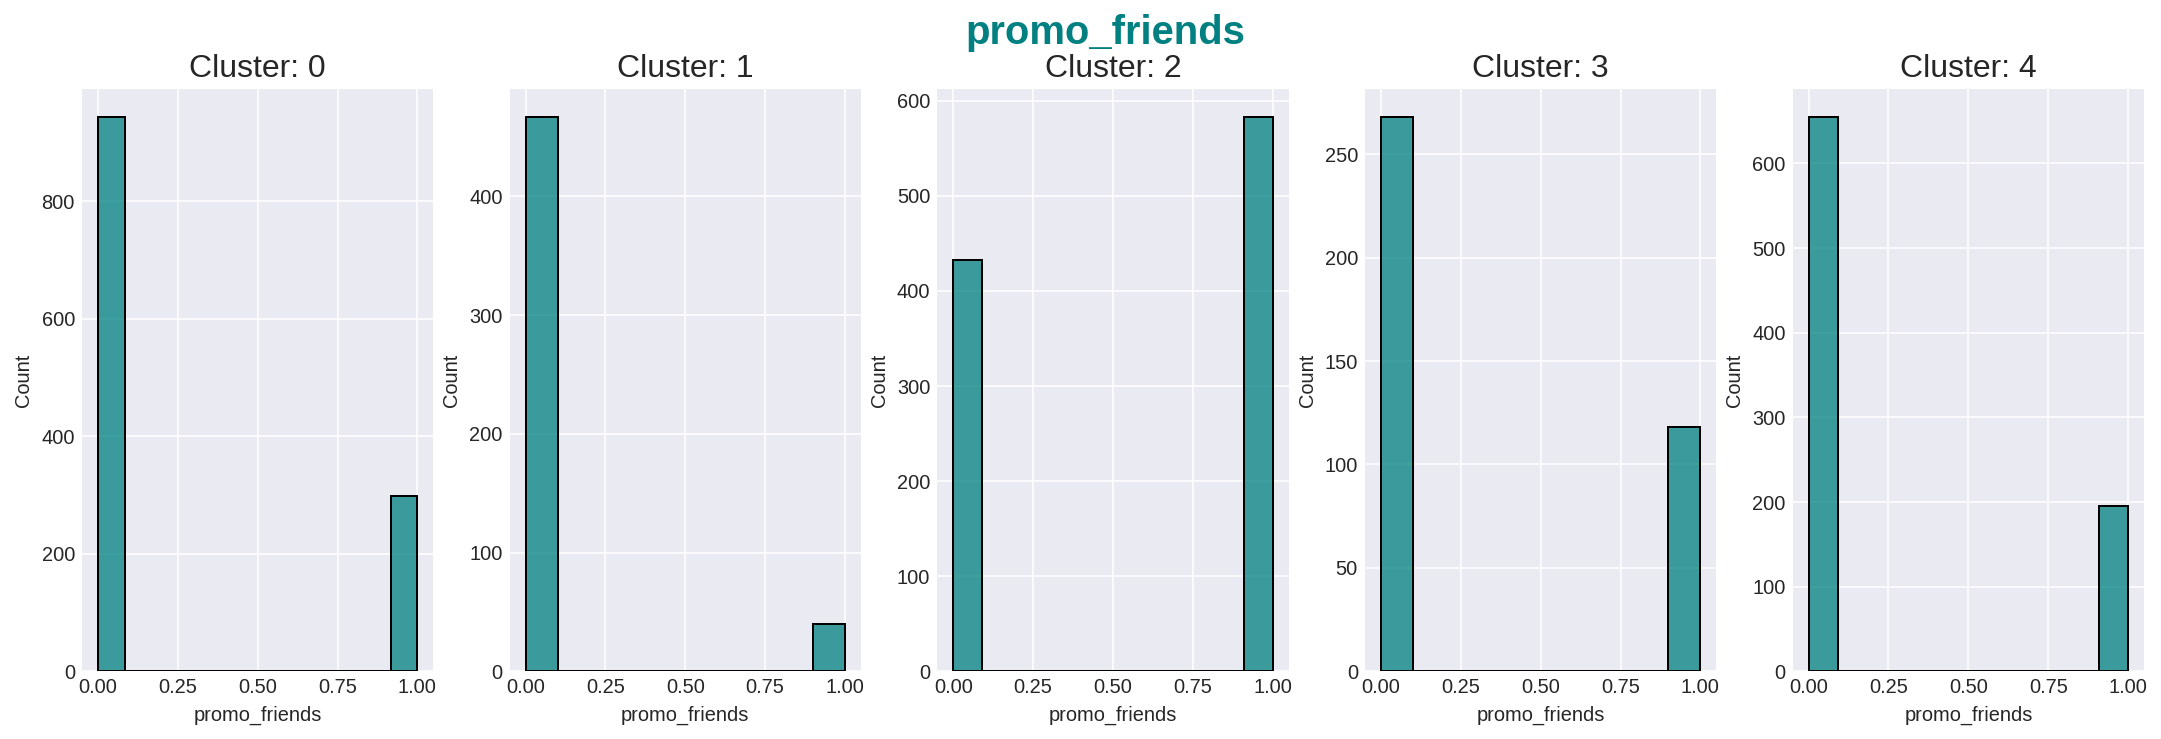

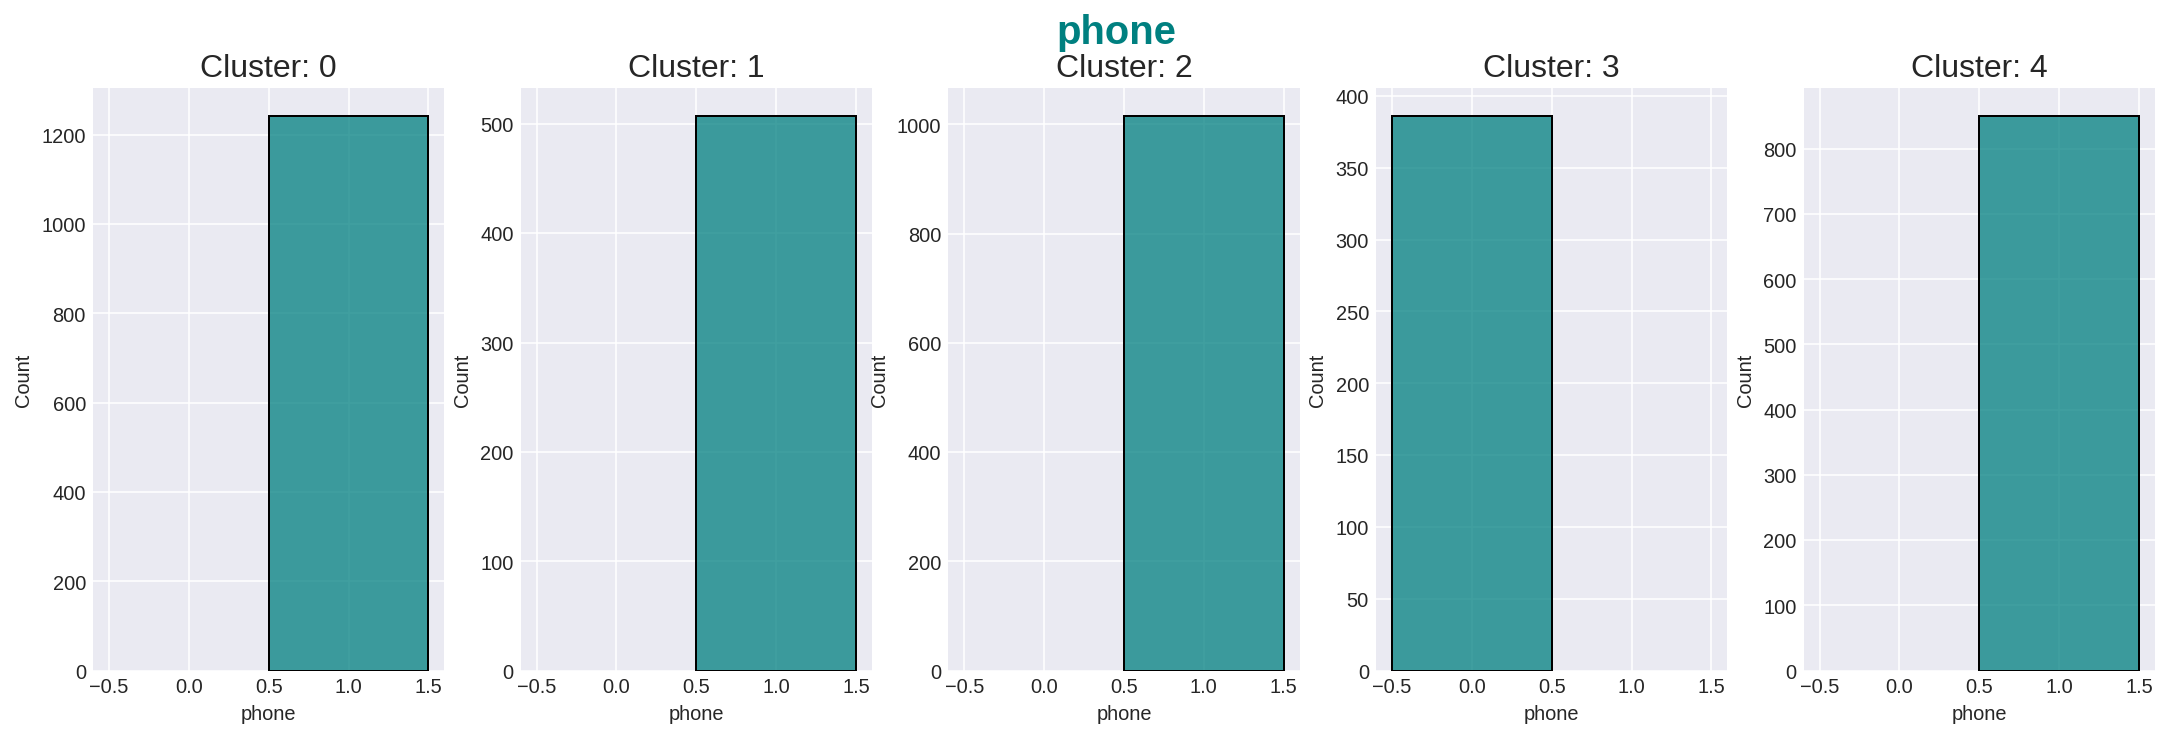

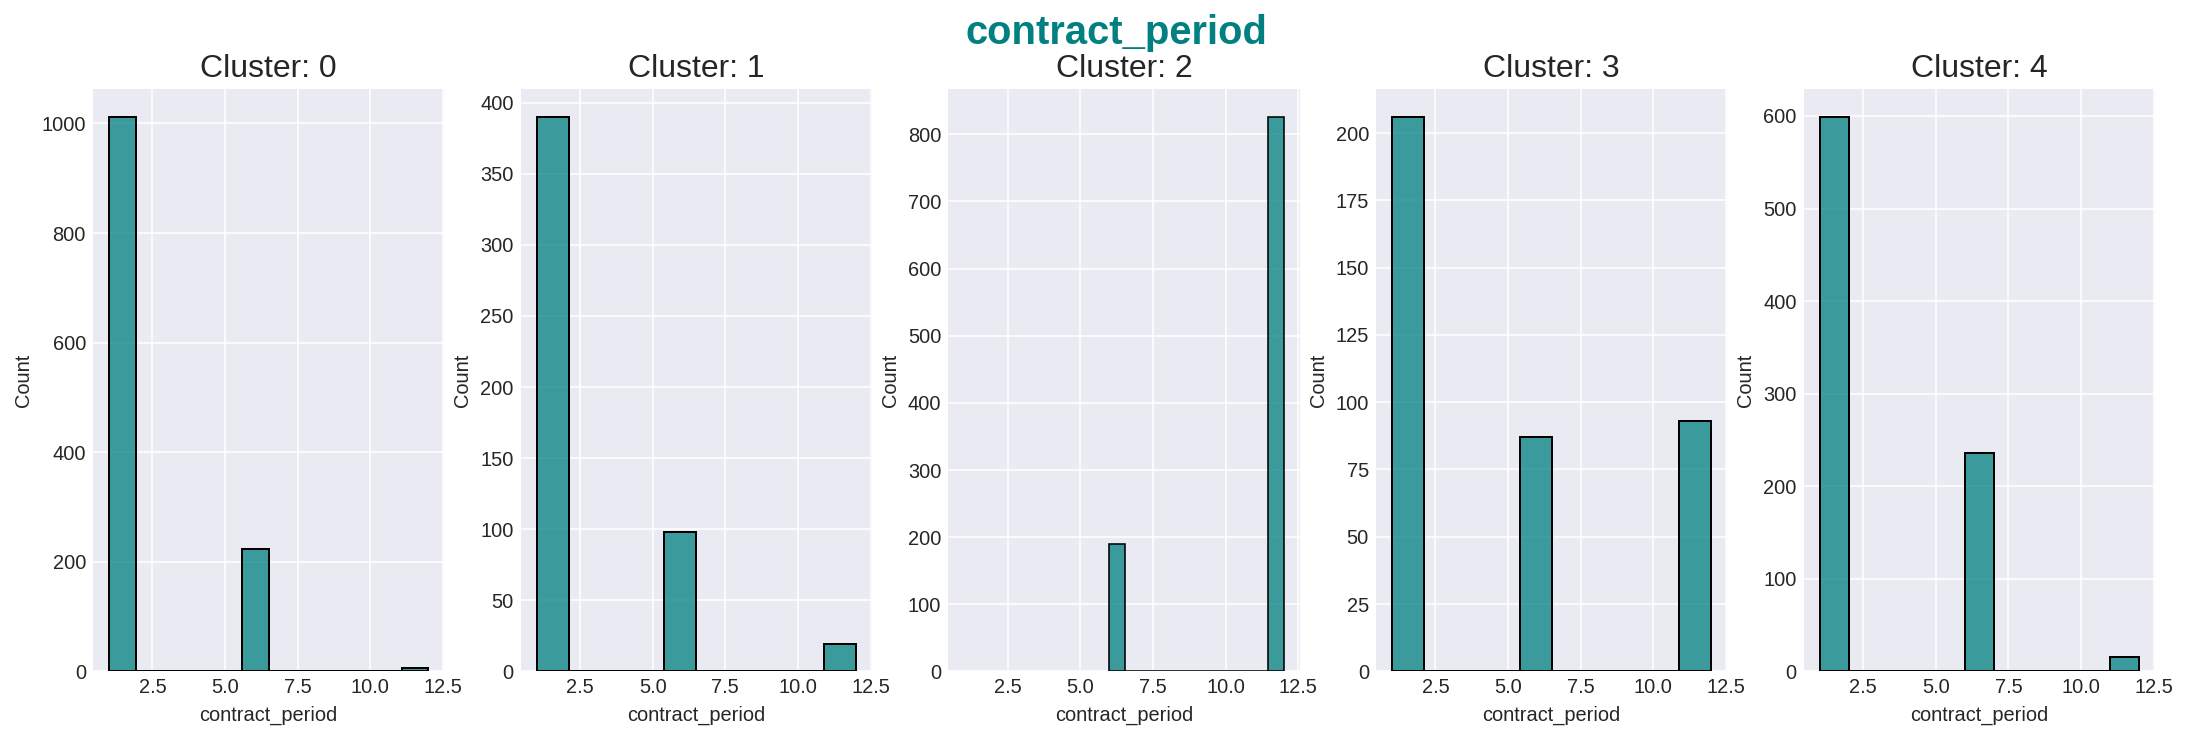

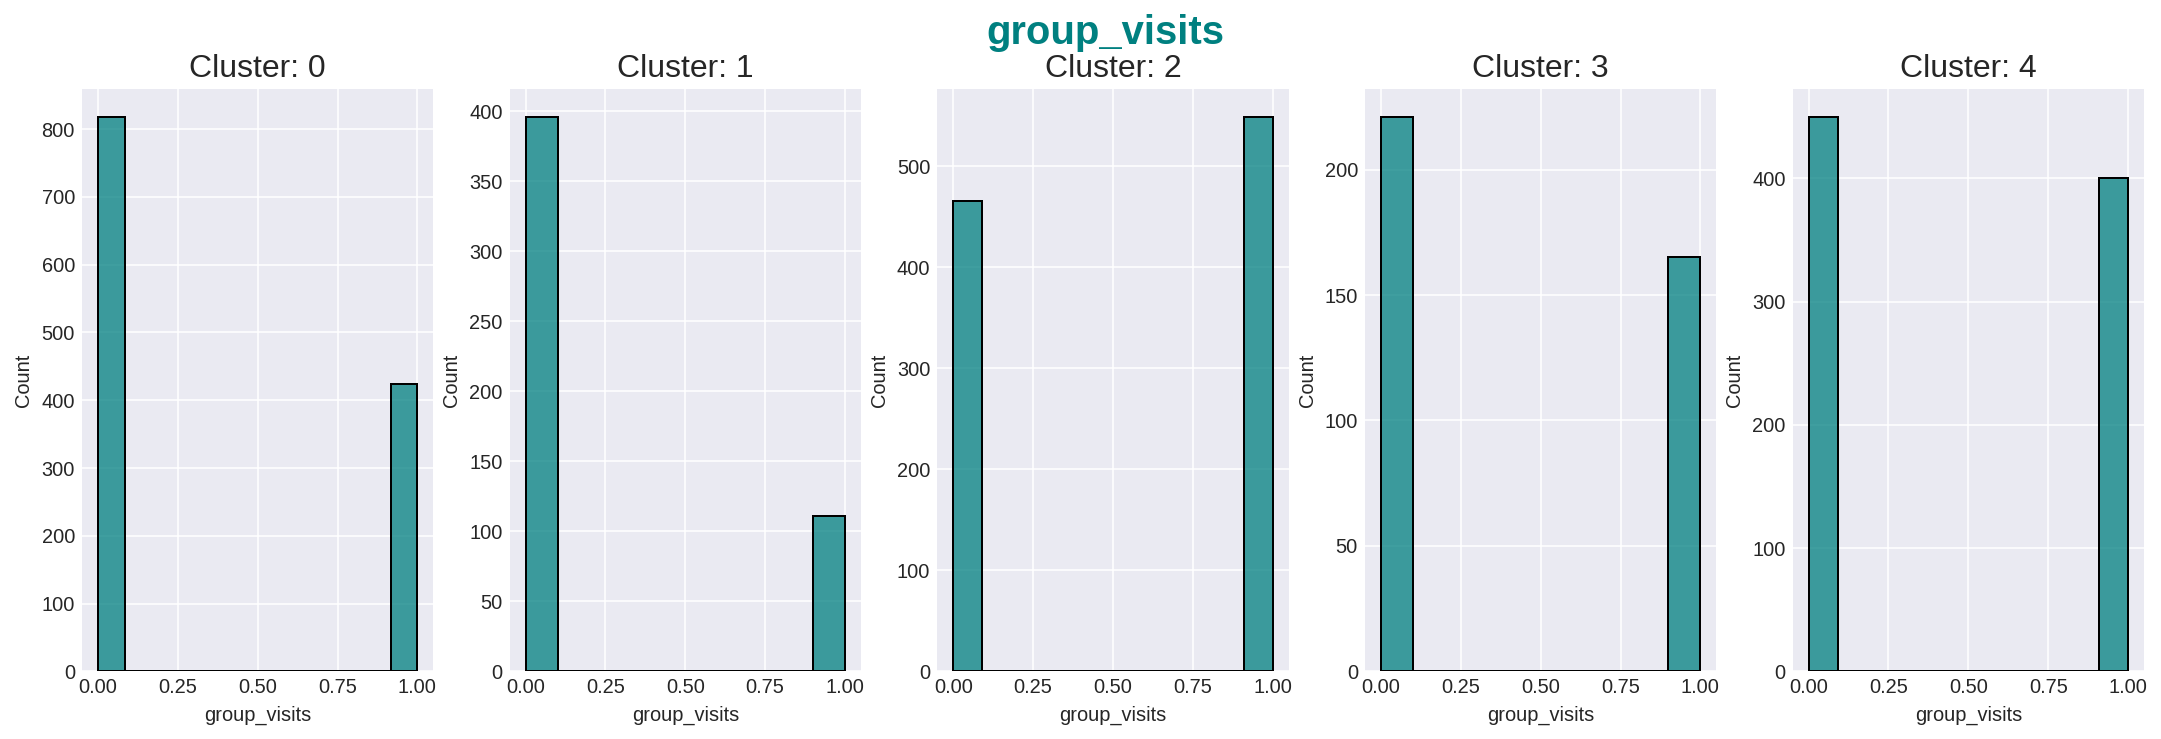

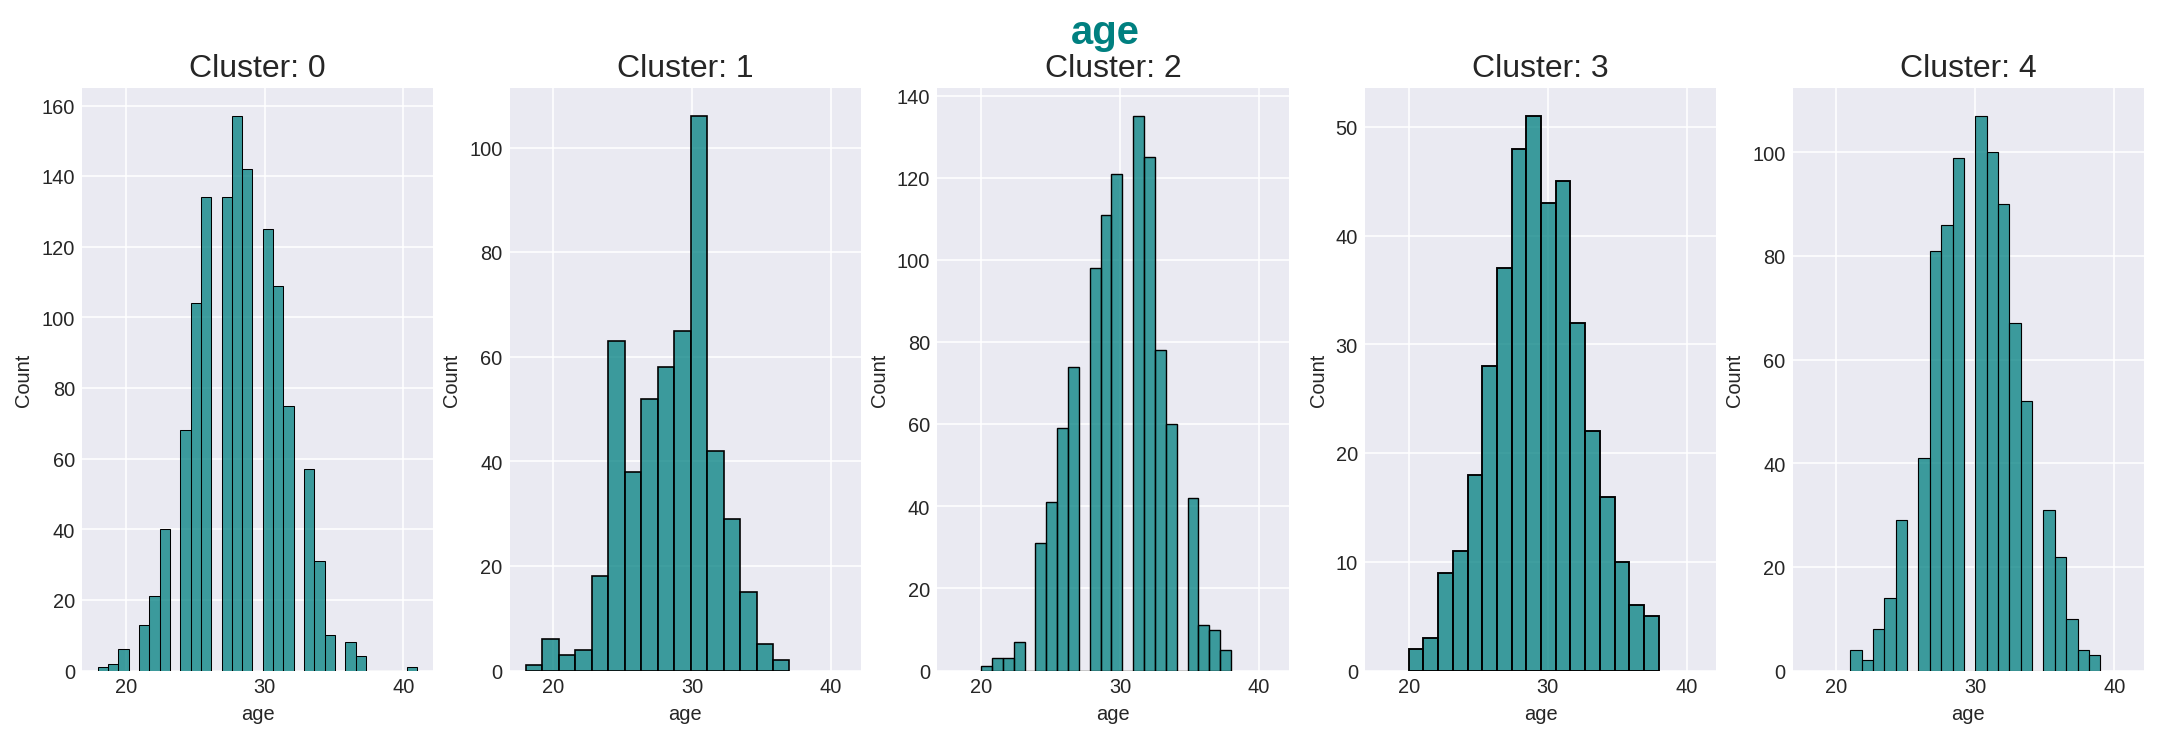

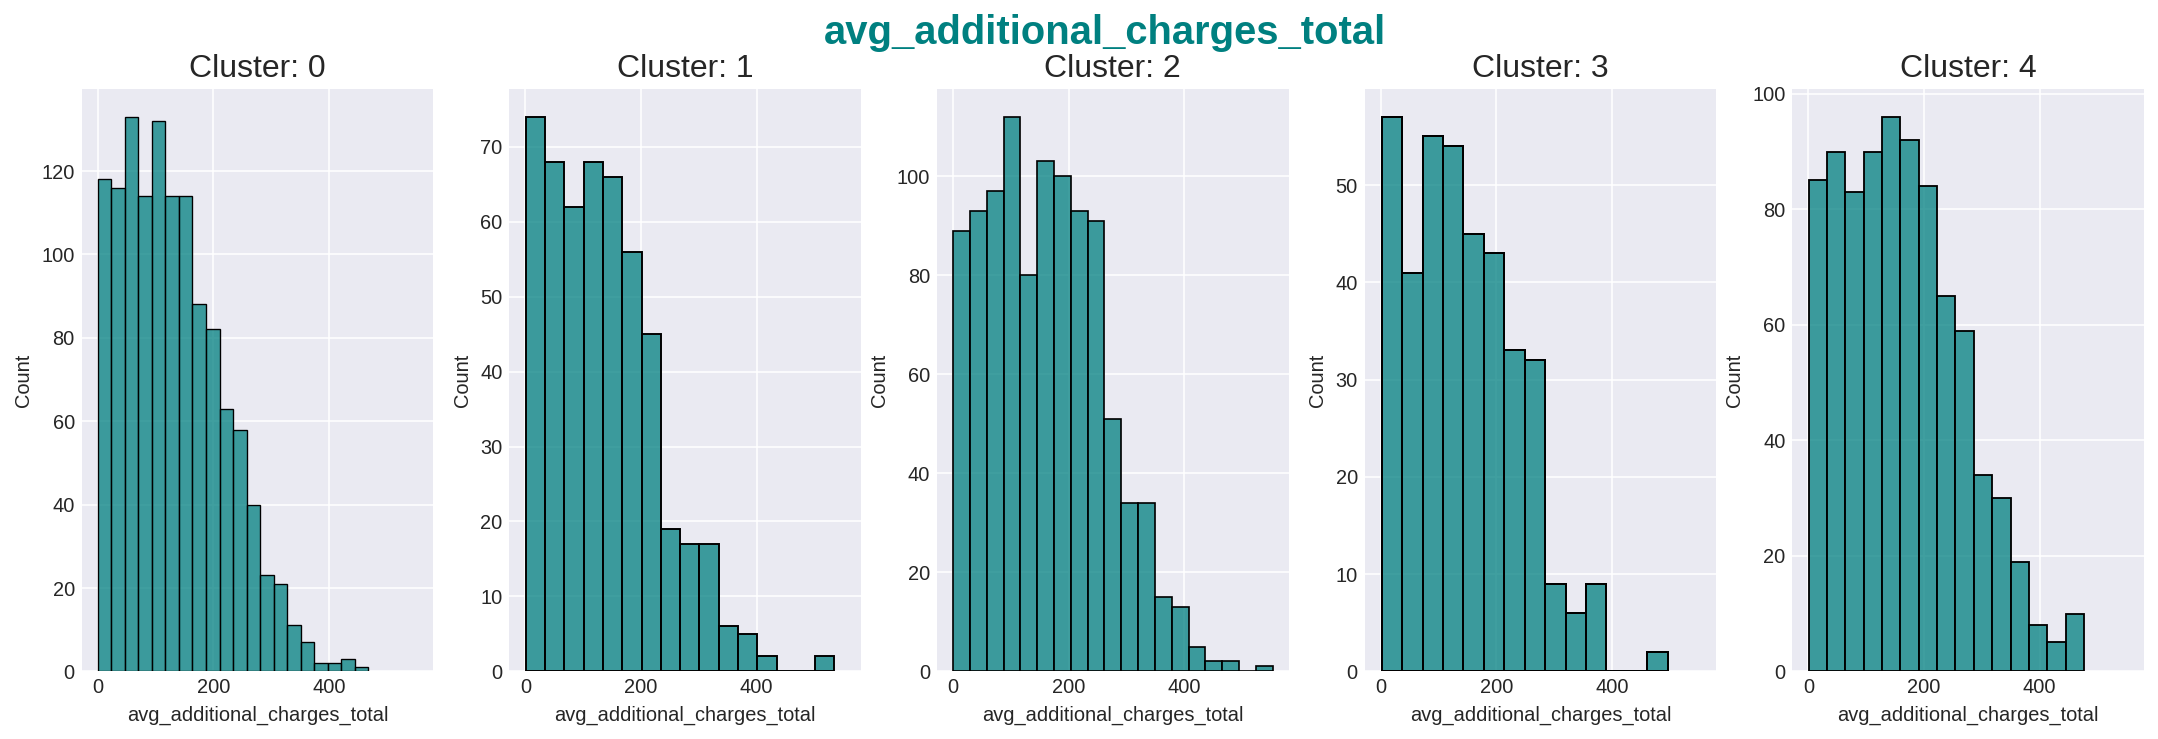

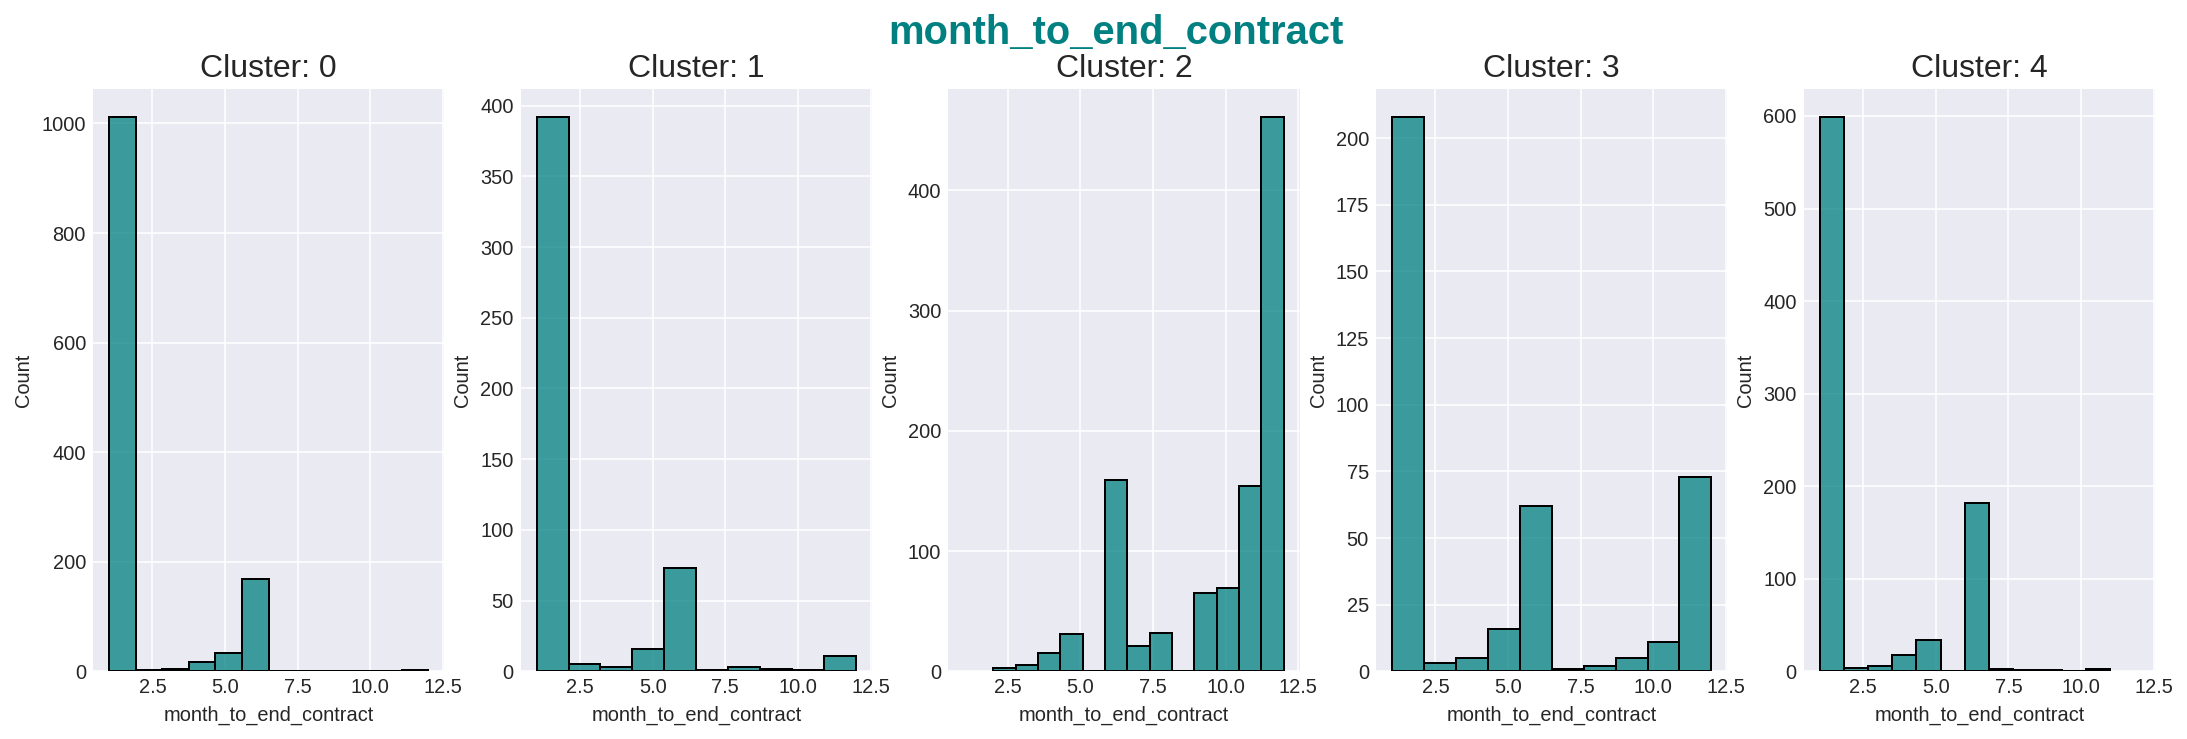

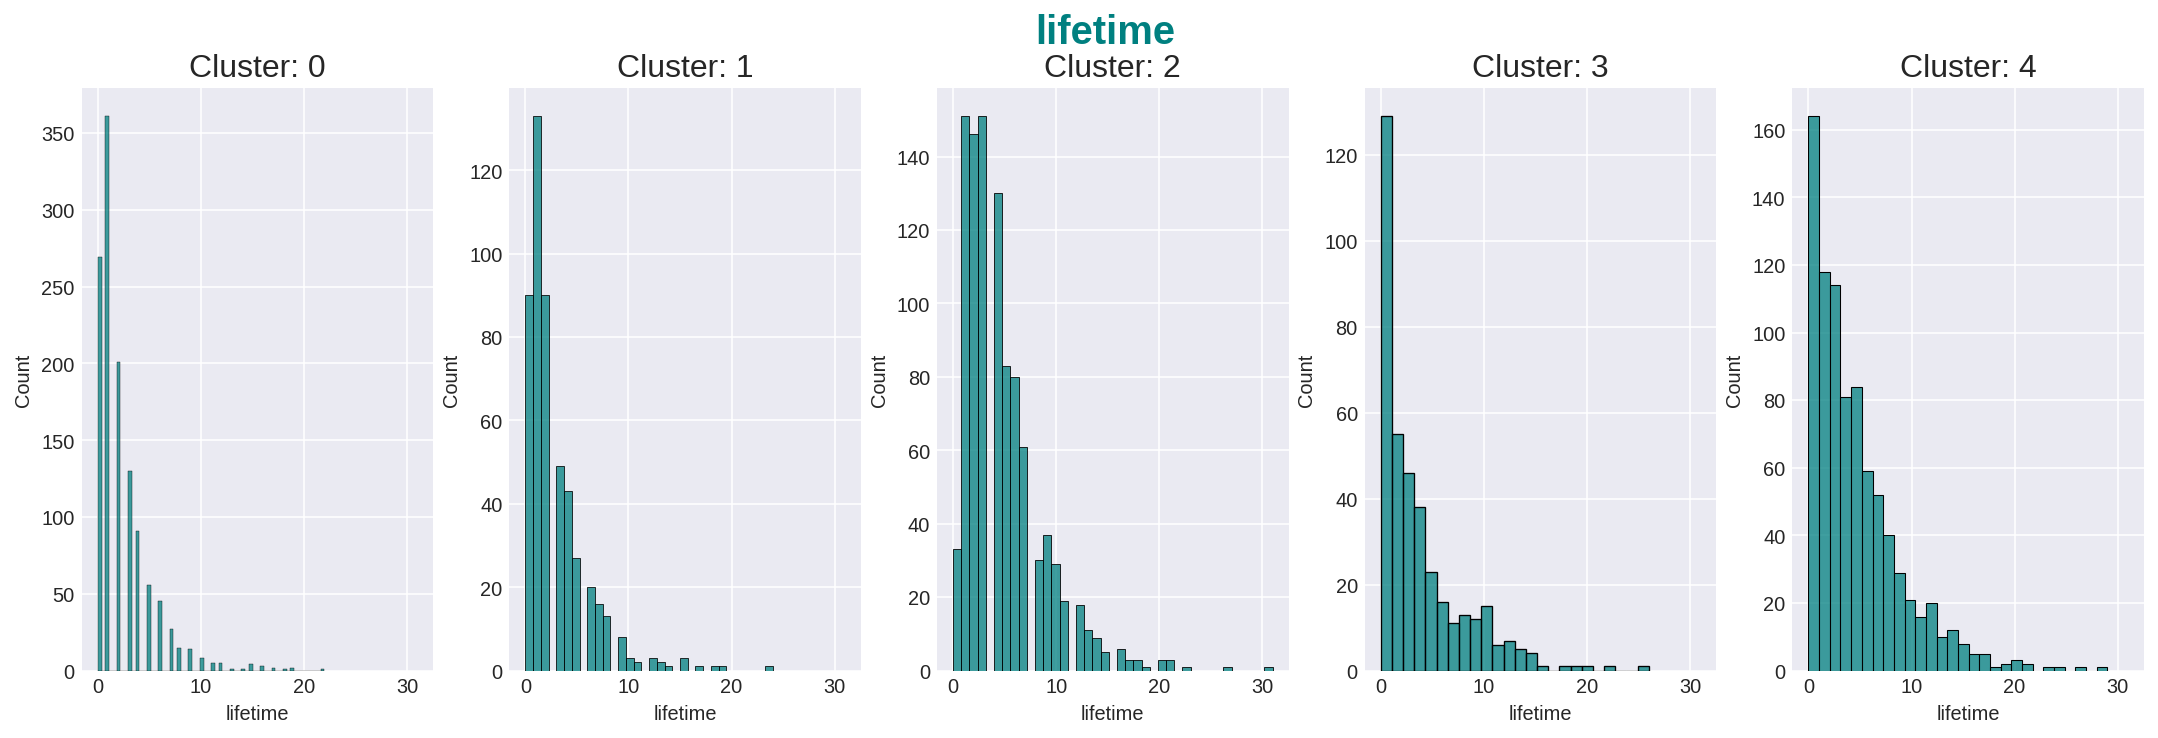

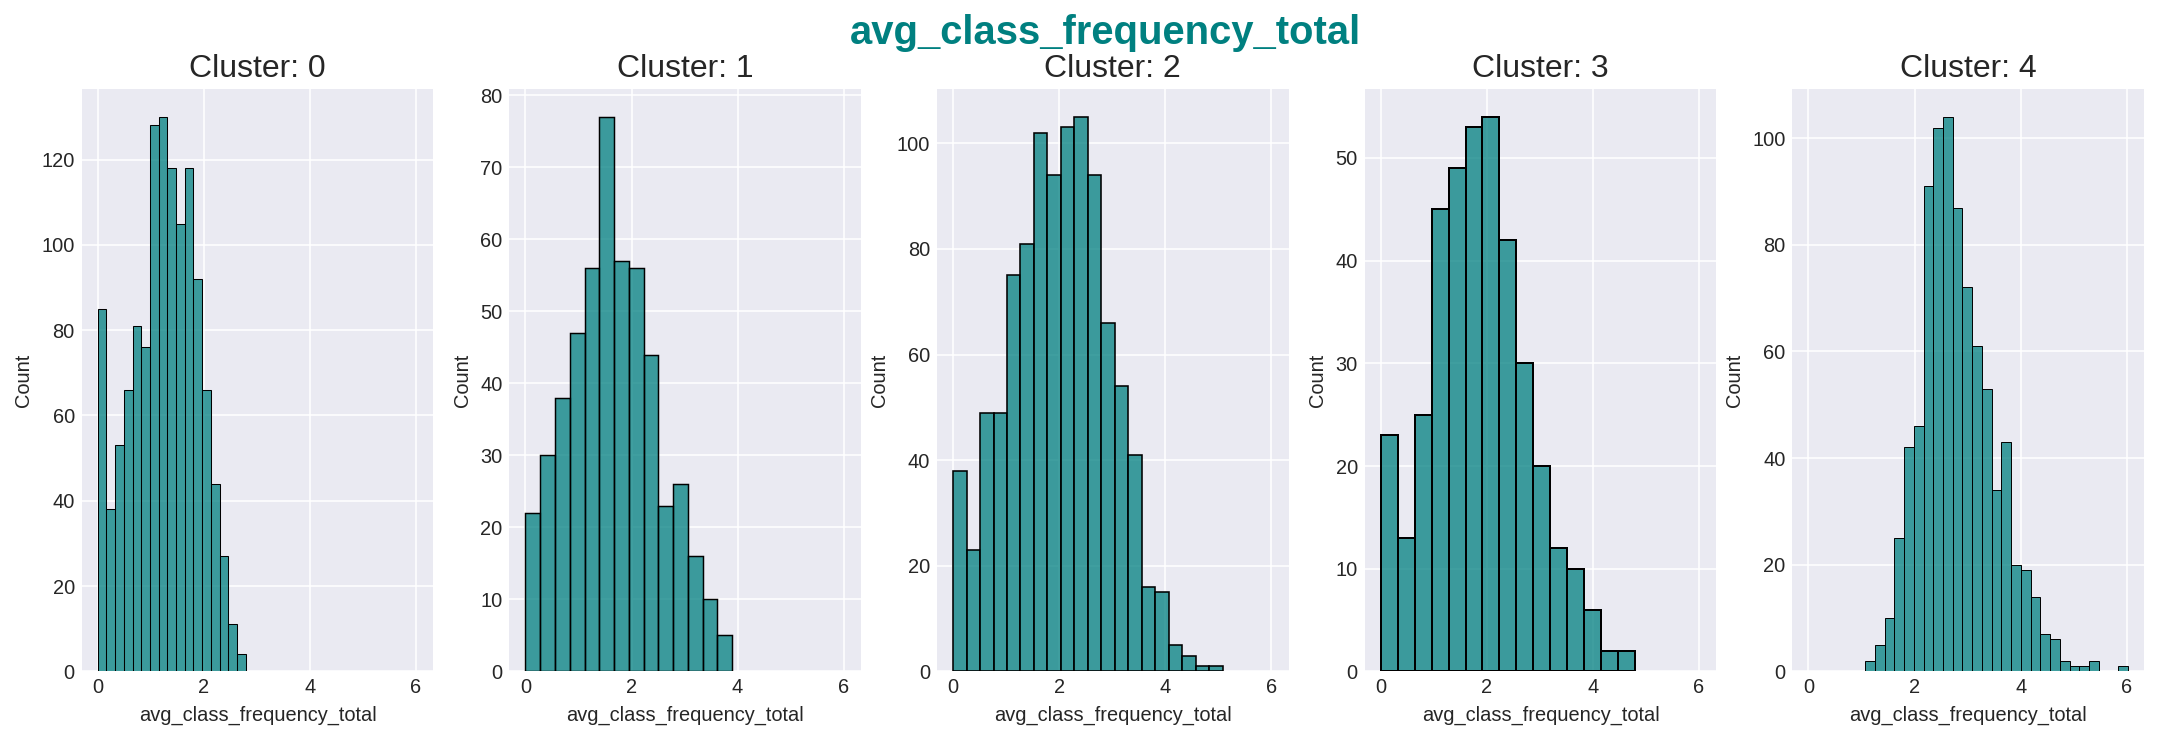

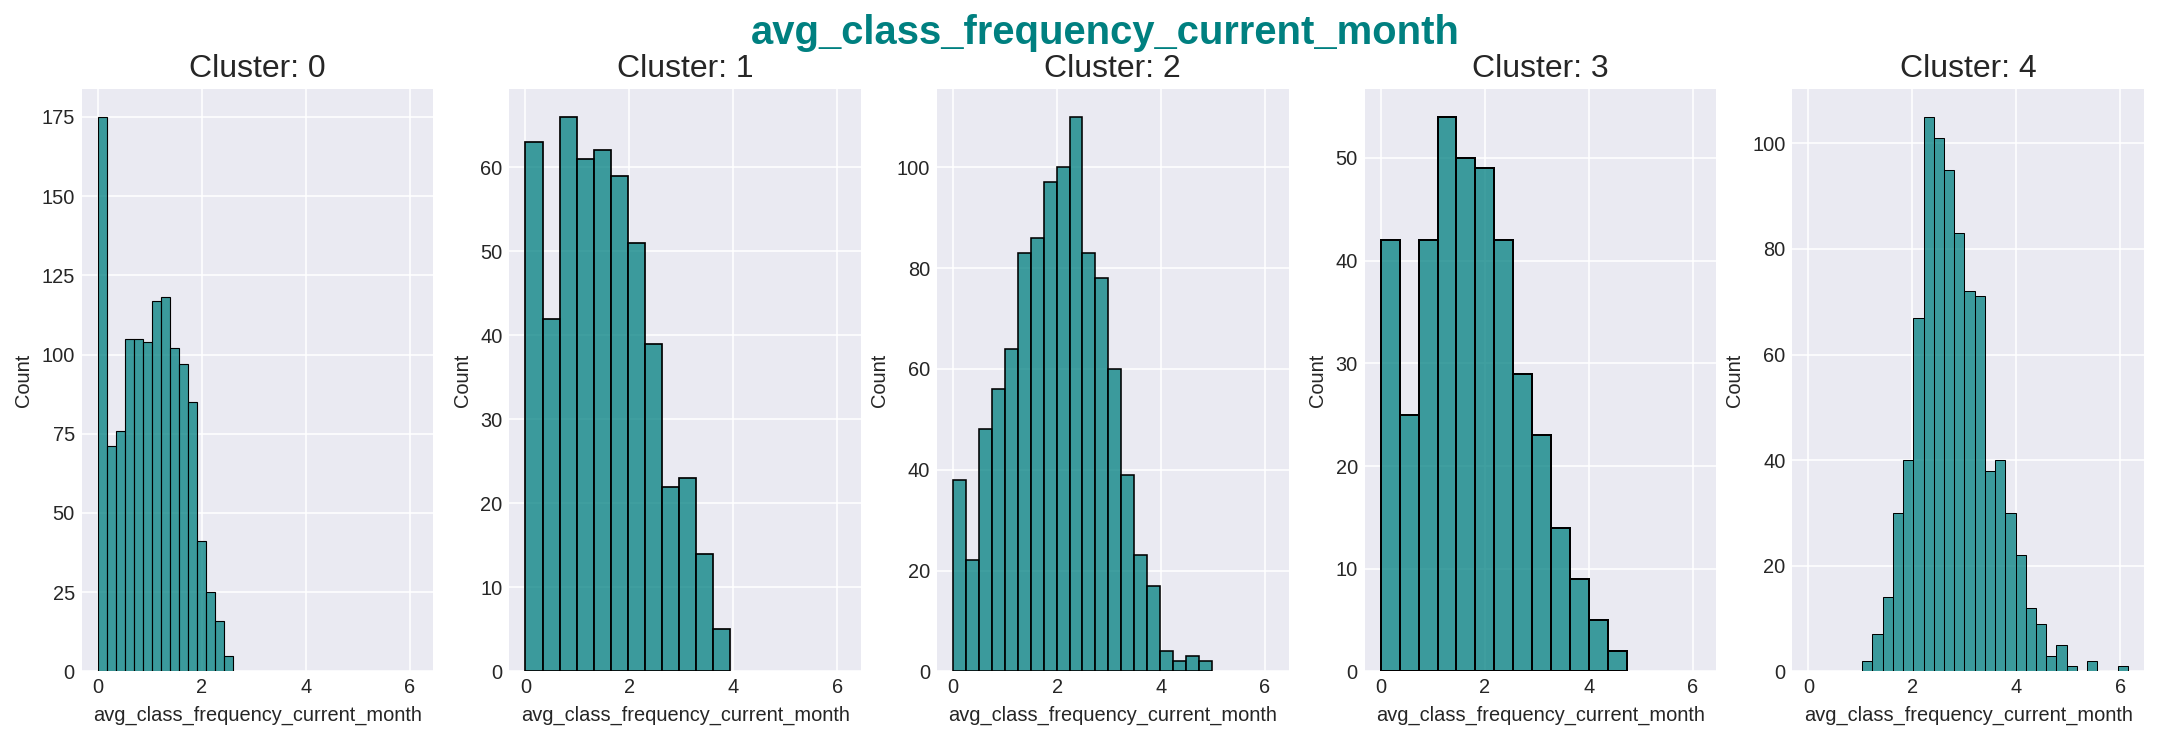

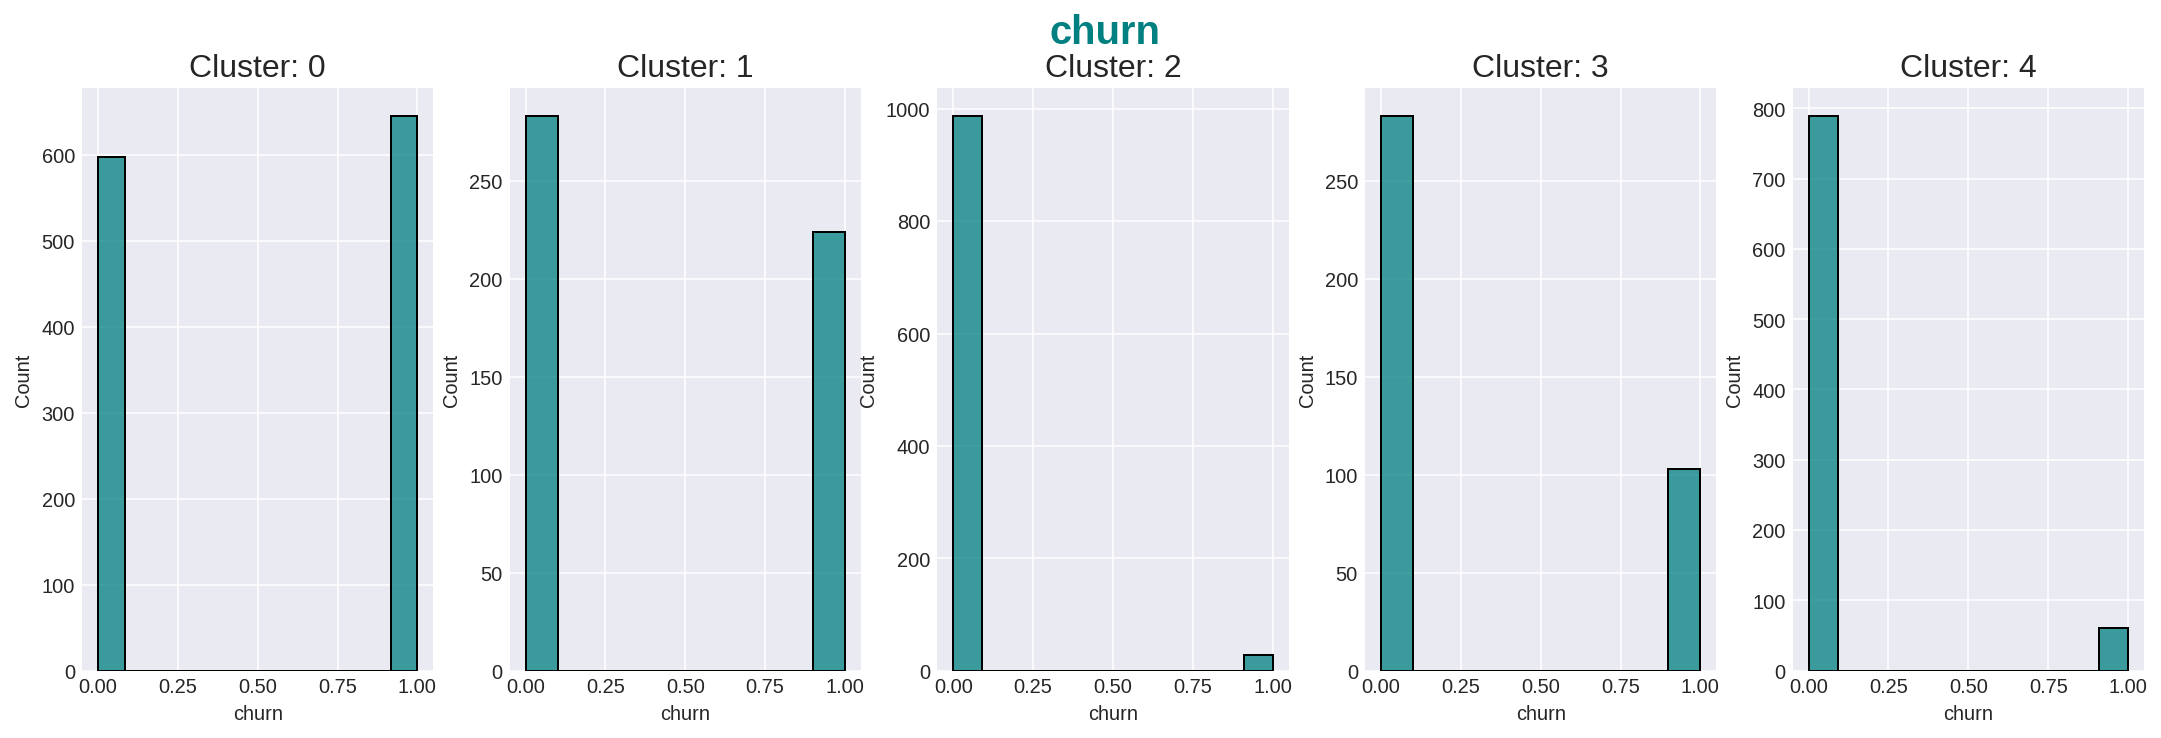

In [42]:
double_hist('cluster')

Выводы полностью совпадают с описанными выше. Можно также добавить:
1. Среди клиентов последнего кластера нет людей, не ходящих в зал. Левый хвост распеределения упирается в единицу. При этом среди них почти нет людей с годовым абонементом.
2. Клиенты кластера 2 в основном имеют абонемент на год, но среди них около 40 человек почти не ходят в зал.

Ещё раз взглянем на кластеры и их коэффициент оттока.

In [43]:
(
    df
        .groupby('cluster', as_index=False)
        ['churn']
        .mean()
        .sort_values('churn', ascending=False)
)

,cluster,churn
0,0,0.519324
1,1,0.441815
3,3,0.266839
4,4,0.071765
2,2,0.027586


## Итоговые выводы

В ходе проекта мы изучили и обработали данные, визуализировали их для более глубокого понимания причин ухода клиентов. Для прогнозирования оттока применили машинное обучение: бинарную классификацию и кластеризацию. В результате:
1. Мы обучили модель, которая успешно выявляет 81% клиентов, склонных к уходу.
2. Выяснили, что больше всего на отток влияют:
    - близость к клубу,
    - длительность договора,
    - наличие программы лояльности («приведи друга» или скидка от работодателя),
    - активность пользования услугами клуба (частота посещения и дополнительные услуги).

### Рекомендации

1. Клиентам кластера 0 или не хватило мотивации, или что-то не понравилось в клубе. Следует просить уходящих клиентов кратко ответить на вопросы о причинах ухода. Для тех, кому не хватает мотивации, нужно подумать, как её повысить. Например, предложить им услуги персонального тренера со скидкой. Можно также попробовать сделать систему достижений и давать скидки на абонементы или услуги тем, кто часто посещает зал. Редко посещающим зал клиентам можно отправить рассылку, например, с информацией о пользе спорта.
2. Клиентов, которые живут далеко от клуба, вряд ли можно заставить изменить своё решение. Если такая цель есть, может помочь, например, бесплатная парковка на территории.
3. Клиентов нужно мотивировать покупать абонементы на более долгий срок. Можно попробовать делать скидки на полугодовые и годовые договоры. Постоянным клиентам также можно делать скидки на дополнительные услуги. Возможно, стоит распространять акции («приведи друга» или скидка от работодателя) только на длительные абонементы.